In [1]:
import pandas as pd # this library is used for working with DataFrames--very useful in astronomy
import csv # for working with csv files, like you'd see in Microsoft Excel
from matplotlib import pyplot as plt # used for plotting graphs
import numpy as np # all sorts of mathematical applications
import glob # used for grabbing a bunch of files at once
import statistics # the name says it all
import scipy # again, all sorts of mathematical applications
from mpl_toolkits import mplot3d # used for three-dimensional plots, which we'll revisit at a later time
from astroquery import gaia # Gaia!
from astroquery.gaia import Gaia
import astropy.units as u # very handy for keeping track of units, which are very easy to get mixed up
from astropy.units import Quantity
from astropy.coordinates.sky_coordinate import SkyCoord # used for interpreting RA and Dec coordinates
from astropy import table # sometimes astronomy data downloads in tables, which I find incredibly annoying to work with
from astropy.io.votable import parse # used to parse through votable files (again, often seen in astronomy)
from scipy.stats import norm # some extra stats stuff I've used for fitting
from scipy.stats import powerlaw
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit
from scipy.optimize import least_squares
import math
import astropy.units as u
from astropy.coordinates.sky_coordinate import SkyCoord
from astroquery.vizier import Vizier

import seaborn as sns # super cool library that allows us to make contour plots and cool data visualizations
from astroquery.ipac.irsa import sha # some extra imports for downloading data
from astropy import coordinates as coord
from astroquery.ipac.irsa import Irsa
import numpy.ma as ma
Irsa.ROW_LIMIT = 40000 # limits the number of rows that a query returns so that the query doesn't run forever--just make sure

/Users/zeinakellybenton/anaconda3/lib/python3.10/site-packages/astroquery/ipac/irsa/sha/__init__.py:14: UserWarning: Experimental: SHA has not yet been refactored to have its API match the rest of astroquery.
  warnings.warn("Experimental: SHA has not yet been refactored to have its "


In [2]:
Gaia.ROW_LIMIT = 100000
onc_ra = 100.25
onc_dec = 9.88
coord = SkyCoord(ra = onc_ra, dec = onc_dec, unit=(u.degree, u.degree), frame='icrs') 
#ICRS = International Celestial Reference System
#then, you define the size of the area you'd like to look at. Here, we'll look at a cone with a radius of half a degree 
job = Gaia.cone_search_async(coord, radius=u.Quantity(0.24, u.deg))

results = job.get_results()

dictionary = {}
for name in results.colnames:
    dictionary[str(name)] = results[str(name)]
gaia = pd.DataFrame(data=dictionary)

INFO: Query finished. [astroquery.utils.tap.core]


In [3]:
import pandas as pd

def filter_gaia_data(gaia_df):
    # Drop rows with NaN values in 'parallax' and 'parallax_error' columns
    gaia_df = gaia_df.dropna(subset=['parallax', 'parallax_error'])
    
    # Create a new DataFrame to store calculations
    result_df = gaia_df.copy()
    
    # Calculate distance from parallax (in parsecs)
    result_df['distance'] = 1 / ((10**-3) * abs(result_df['parallax']))
    
    # Filter based on distance and parallax_error
    result_df = result_df[(result_df['distance'] >= 100) & (result_df['distance'] <= 1300)]
    result_df = result_df[result_df['parallax_error'] <= 0.3]  # Filter out rows where parallax_error < 0.25

    return result_df.reset_index(drop=True)

# Usage
gaia = pd.DataFrame(data=dictionary)  # Assuming you have your dictionary defined
gaia_v2 = filter_gaia_data(gaia)
print(gaia_v2)


#NORTH GAIA SEARCH C1

             solution_id                   DESIGNATION            SOURCE_ID  \
0    1635721458409799680  Gaia DR2 3326740693770240640  3326740693770240640   
1    1635721458409799680  Gaia DR2 3326740762491769088  3326740762491769088   
2    1635721458409799680  Gaia DR2 3326740758201316608  3326740758201316608   
3    1635721458409799680  Gaia DR2 3326740693772848896  3326740693772848896   
4    1635721458409799680  Gaia DR2 3326740689481840896  3326740689481840896   
..                   ...                           ...                  ...   
679  1635721458409799680  Gaia DR2 3326934276538636288  3326934276538636288   
680  1635721458409799680  Gaia DR2 3326749932245991296  3326749932245991296   
681  1635721458409799680  Gaia DR2 3326709215956587264  3326709215956587264   
682  1635721458409799680  Gaia DR2 3326938635928587520  3326938635928587520   
683  1635721458409799680  Gaia DR2 3326936093309982592  3326936093309982592   

     random_index  ref_epoch          ra  ra_error 

In [4]:
import pyvo


SIMBAD_ra = 100.25
SIMBAD_dec = 9.88
surv_ra = SIMBAD_ra + 0.0013 #5''
surv_dec = SIMBAD_dec + 0.0013

# Prepare the query
query = f"""
    SELECT ra, dec, j_m, j_msigcom, h_m, h_msigcom, k_m, k_msigcom, ph_qual, cc_flg
    FROM fp_psc
    WHERE CONTAINS(POINT('ICRS', ra, dec), CIRCLE('ICRS', {surv_ra}, {surv_dec}, 0.22)) = 1
"""

# Access the TAP service and run the query
service = pyvo.dal.TAPService('https://irsa.ipac.caltech.edu/TAP')
result = service.run_async(query)

# Handle the result
try:
    TwoMASS = result.to_table()
    print(TwoMASS)
    
    # Making necessary 4 lists
    ra_G = gaia_v2['ra'].tolist()  # Replace 'df' with your Gaia DataFrame if needed
    dec_G = gaia_v2['dec'].tolist()  # Replace 'df' with your Gaia DataFrame if needed
    ra_TM = TwoMASS['ra'].tolist()
    dec_TM = TwoMASS['dec'].tolist()
    
except Exception as e:
    print(f"An error occurred: {e}")

    ra        dec     j_m   j_msigcom  h_m   ...  k_m   k_msigcom ph_qual cc_flg
   deg        deg     mag      mag     mag   ...  mag      mag                  
---------- --------- ------ --------- ------ ... ------ --------- ------- ------
100.184806 10.046662 14.361     0.037 14.011 ... 13.833     0.051     AAA    000
100.168597 10.047357 16.047     0.081 15.516 ... 15.003     0.126     AAB    000
100.175188 10.040696 16.065     0.112 15.388 ... 15.176     0.171     BAC    000
100.170251 10.050909 16.144        -- 15.809 ... 16.249        --     UBU    000
100.177642 10.041435 16.263     0.149 15.805 ... 15.324     0.203     BBC    000
100.179467 10.072316 16.928     0.204 15.943 ... 15.009        --     DBU    000
100.181967 10.067764 16.232     0.139 15.538 ... 15.075     0.170     BBC    000
100.146324 10.072726 12.229     0.026 11.537 ... 11.368     0.021     AAA    000
100.162684 10.060035 16.345     0.112 15.586 ... 15.077     0.173     BBC    000
       ...       ...    ... 

In [5]:
from scipy.spatial import distance

tolerance = 0.0005

def find_shared_pointsN(ra_G, dec_G, ra_TM, dec_TM, tolerance):
	shared = []
	only_gaia = []
	only_2mass = []
	for i in range(len(ra_G)):
		point_A = np.array([ra_G[i], dec_G[i]])
		found_shared = False
		for j in range(len(ra_TM)):
			point_B = np.array([ra_TM[j], dec_TM[j]])
			if distance.euclidean(point_A, point_B) < tolerance:
				shared.append((ra_G[i], dec_G[i]))
				found_shared = True
				break
		if not found_shared:
			only_gaia.append((ra_G[i], dec_G[i]))
	for j in range(len(ra_TM)):
		point_2mass = np.array([ra_TM[j], dec_TM[j]])
		if not any(distance.euclidean(point_B, np.array(p)) < tolerance for p in shared):
			only_2mass.append((ra_TM[j], dec_TM[j]))
	return np.array(shared), np.array(only_gaia), np.array(only_2mass)

shared_points, only_A_points, only_B_points = find_shared_pointsN(ra_G, dec_G, ra_TM, dec_TM, tolerance)


In [6]:
#north gaia only

onlyA_ra_values = {point[0] for point in only_A_points}
gaia_indices = []
for i, ra_value in enumerate(gaia_v2['ra']):
	if ra_value in onlyA_ra_values:
		gaia_indices.append(i)

gaia = pd.DataFrame(data=dictionary)
gaia_indices = set(gaia_indices)
gaiaN_data = gaia.loc[gaia.index.intersection(gaia_indices)]
len(gaiaN_data)


82

In [7]:
#north 2mass/ gaia shared data

shared_ra_values = {point[0] for point in shared_points}
gaia_shared_indices = []
for i, ra_value in enumerate(gaia_v2['ra']):
	if ra_value in shared_ra_values:
		gaia_shared_indices.append(i)

gaia = pd.DataFrame(data=dictionary)
gaia_shared_indices = set(gaia_shared_indices)
sharedN_data = gaia.loc[gaia.index.intersection(gaia_shared_indices)]

len(sharedN_data)

602

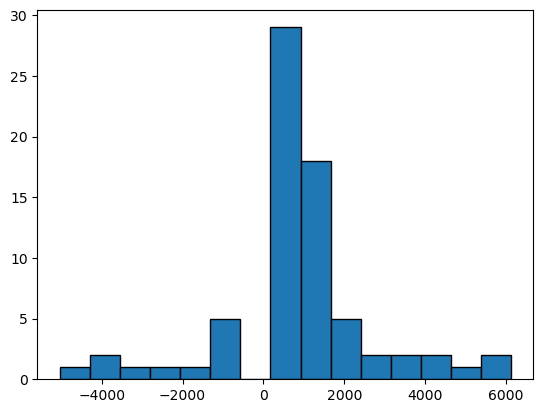

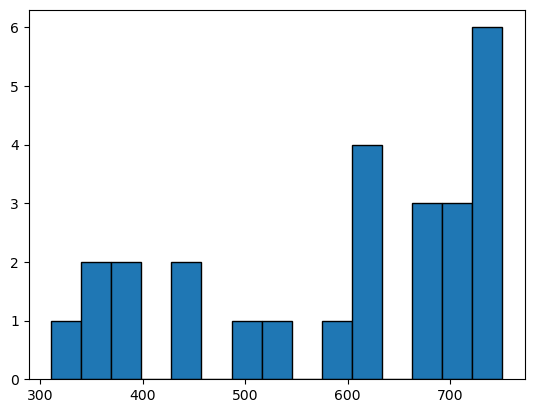

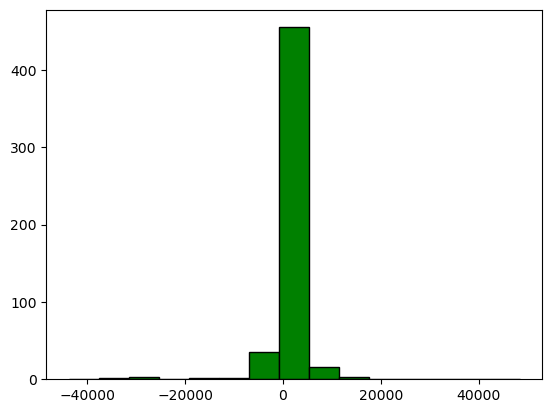

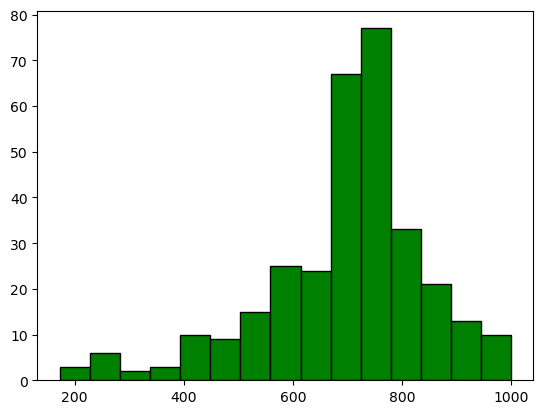

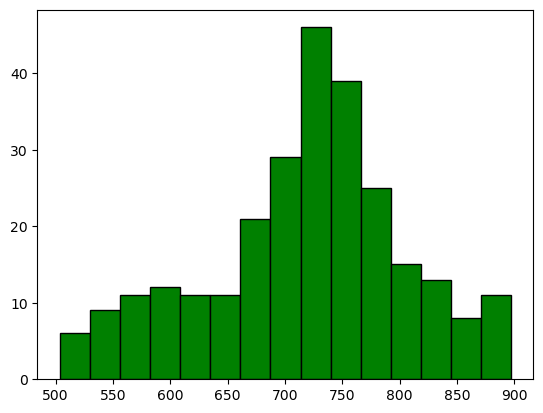

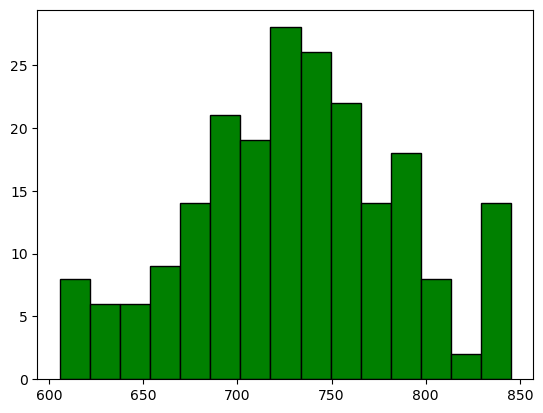

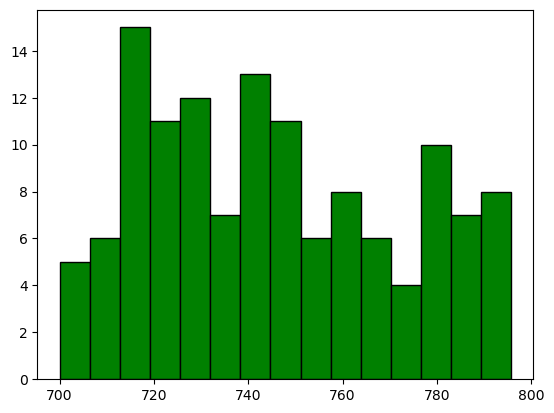

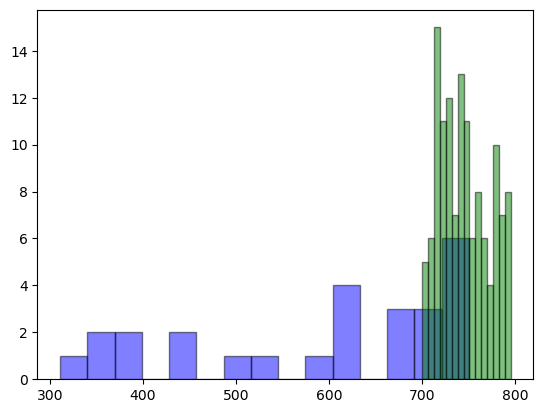

In [8]:
#different north plot display
# gaia Distance Histogram
parallax_as = gaiaN_data['parallax'] / 1000
distances_pcG = 1 / parallax_as
plt.hist(distances_pcG, bins = 15, edgecolor='black')
plt.show()

# Filtering outliers
filtered_distances = [dist for dist in distances_pcG if 0 < dist < 800]
distances_blues = [abs(dist) for dist in filtered_distances]
len(distances_blues)
plt.hist(distances_blues, bins = 15, edgecolor='black')
plt.show()



#  shared Distance Histogram
parallax_as = sharedN_data['parallax'] / 1000
distances_pc = 1 / parallax_as
plt.hist(distances_pc, bins = 15, color='green', edgecolor='black')
plt.show()

# Filtering  outliers
filtered_distances = [dist for dist in distances_pc if 0 < dist < 1000]
distances_greenss = [abs(dist) for dist in filtered_distances]
len(distances_greenss)
plt.hist(distances_greenss, bins = 15, color='green', edgecolor='black')
plt.show()

# Filtering  outliers
filtered_distances = [dist for dist in distances_pc if 500 < dist < 900]
distances_greens = [abs(dist) for dist in filtered_distances]
len(distances_greens)
plt.hist(distances_greens, bins = 15, color='green', edgecolor='black')
plt.show()

# Filtering  outliers
filtered_distances = [dist for dist in distances_pc if 600 < dist < 850]
distances_greens = [abs(dist) for dist in filtered_distances]
len(distances_greens)
plt.hist(distances_greens, bins = 15, color='green', edgecolor='black')
plt.show()

# Filtering  outliers
filtered_distances = [dist for dist in distances_pc if 700 < dist < 800]
distances_greens = [abs(dist) for dist in filtered_distances]
len(distances_greens)
plt.hist(distances_greens, bins = 15, color='green', edgecolor='black')
plt.show()



# # Overlaying Histograms
plt.hist(distances_blues, bins=15, alpha=0.5, color='blue', edgecolor='black')
plt.hist(distances_greens, bins=15, alpha=0.5, color='green', edgecolor='black')
plt.show()


In [9]:
#north

#df_shared = pd.DataFrame(shared_points, columns=["RA", "DEC"])
#df_only_gaia = pd.DataFrame(only_A_points, columns=["RA", "DEC"])
#df_only_2mass = pd.DataFrame(only_B_points, columns=["RA", "DEC"])

# Display DataFrames for verification
#print("Shared Points DataFrame:")
#print(df_shared)

#print("\nOnly Gaia Points DataFrame:")
#print(df_only_gaia)

#print("\nOnly 2MASS Points DataFrame:")
#print(df_only_2mass)

In [10]:
from astropy.coordinates import SkyCoord
from astropy import units as u
from astroquery.gaia import Gaia

def fetch_and_filter_gaia_data(ra, dec, radius=0.24):
    # Define coordinates
    coord = SkyCoord(ra=ra, dec=dec, unit=(u.degree, u.degree), frame='icrs')
    
    # Perform cone search
    job = Gaia.cone_search_async(coord, radius=u.Quantity(radius, u.deg))
    results = job.get_results()
    
    # Convert to pandas DataFrame
    gaia_df = results.to_pandas()
    
    # Drop rows with NaN values in 'parallax' column
    gaia_df = gaia_df.dropna(subset=['parallax'])
    
    # Create a new DataFrame for calculations
    filtered_df = gaia_df.copy()
    
    # Calculate distance from parallax
    filtered_df['distance'] = 1 / ((10**-3) * abs(filtered_df['parallax']))
    
    # Filter distances
    filtered_df = filtered_df[(filtered_df['distance'] >= 100) & (filtered_df['distance'] <= 1300)]
    filtered_df = filtered_df[filtered_df['parallax_error'] <= 0.3] 
    
    return filtered_df.reset_index(drop=True)

# Usage
onc_ra1 = 100.27  # degrees
onc_dec1 = 9.50

gaia1 = fetch_and_filter_gaia_data(onc_ra1, onc_dec1)
print(gaia1)


#SOUTH CLUSTER GAIA SURVEY C2

INFO: Query finished. [astroquery.utils.tap.core]
             solution_id                   DESIGNATION            SOURCE_ID  \
0    1635721458409799680  Gaia DR2 3326686710327852160  3326686710327852160   
1    1635721458409799680  Gaia DR2 3326686714623729664  3326686714623729664   
2    1635721458409799680  Gaia DR2 3326689665265356160  3326689665265356160   
3    1635721458409799680  Gaia DR2 3326686641609225344  3326686641609225344   
4    1635721458409799680  Gaia DR2 3326686645904252416  3326686645904252416   
..                   ...                           ...                  ...   
633  1635721458409799680  Gaia DR2 3326699801388622208  3326699801388622208   
634  1635721458409799680  Gaia DR2 3326592912538202240  3326592912538202240   
635  1635721458409799680  Gaia DR2 3326688157732390784  3326688157732390784   
636  1635721458409799680  Gaia DR2 3326589785802012928  3326589785802012928   
637  1635721458409799680  Gaia DR2 3326588578914937600  3326588578914937600   

 

In [11]:
import pyvo

SIMBAD_ra1 = 100.27
SIMBAD_dec1 = 9.50
surv_ra = SIMBAD_ra1 + 0.00138889 #5''
surv_dec = SIMBAD_dec1 + 0.00138889

# Prepare the query
query = f"""
    SELECT ra, dec, j_m, j_msigcom, h_m, h_msigcom, k_m, k_msigcom, ph_qual, cc_flg
    FROM fp_psc
    WHERE CONTAINS(POINT('ICRS', ra, dec), CIRCLE('ICRS', {surv_ra}, {surv_dec}, 0.22)) = 1
"""

# Access the TAP service and run the query
service = pyvo.dal.TAPService('https://irsa.ipac.caltech.edu/TAP')
result = service.run_async(query)

# Handle the result
try:
    TwoMASSs = result.to_table()
    print(TwoMASSs)
    
    # Making necessary 4 lists
    ra_G1 = gaia1['ra'].tolist()  # Replace 'df' with your Gaia DataFrame if needed
    dec_G1 = gaia1['dec'].tolist()  # Replace 'df' with your Gaia DataFrame if needed
    ra_TM1 = TwoMASSs['ra'].tolist()
    dec_TM1 = TwoMASSs['dec'].tolist()
    
except Exception as e:
    print(f"An error occurred: {e}")
#SOUTH CL2 GAIA

    ra       dec     j_m   j_msigcom  h_m   ...  k_m   k_msigcom ph_qual cc_flg
   deg       deg     mag      mag     mag   ...  mag      mag                  
---------- -------- ------ --------- ------ ... ------ --------- ------- ------
100.173466 9.670743 16.173     0.113 15.046 ... 14.461     0.106     BAA    cc0
100.189171 9.674918 15.530     0.076 15.086 ... 14.794     0.119     AAB    000
100.181670 9.678436 14.457     0.039 13.130 ... 12.568     0.030     AAA    000
100.198171 9.675864 15.209     0.061 14.458 ... 14.452     0.094     AAA    000
100.174368 9.694059 14.355     0.029 13.665 ... 13.464     0.054     AAA    000
100.175748 9.698071 17.192     0.276 15.979 ... 15.303     0.192     DCC    000
100.187954 9.691310 16.060     0.100 15.124 ... 14.683     0.114     AAB    000
100.256771 9.677723 17.224        -- 15.654 ... 15.290     0.171     UBC    000
100.224874 9.704273 13.510     0.030 12.341 ... 11.826     0.024     AAA    000
       ...      ...    ...       ...    

In [12]:
from scipy.spatial import distance

tolerance = 0.0005

def find_shared_pointsS(ra_G1, dec_G1, ra_TM1, dec_TM1, tolerance):
	sharedS = []
	only_gaiaS = []
	only_2massS = []
	for i in range(len(ra_G1)):
		point_A = np.array([ra_G1[i], dec_G1[i]])
		found_shared = False
		for j in range(len(ra_TM1)):
			point_B = np.array([ra_TM1[j], dec_TM1[j]])
			if distance.euclidean(point_A, point_B) < tolerance:
				sharedS.append((ra_G1[i], dec_G1[i]))
				found_shared = True
				break
		if not found_shared:
			only_gaiaS.append((ra_G1[i], dec_G1[i]))
	for j in range(len(ra_TM1)):
		point_2mass = np.array([ra_TM1[j], dec_TM1[j]])
		if not any(distance.euclidean(point_B, np.array(p)) < tolerance for p in sharedS):
			only_2massS.append((ra_TM1[j], dec_TM1[j]))
	return np.array(sharedS), np.array(only_gaiaS), np.array(only_2massS)

shared_points, only_A_points, only_B_points = find_shared_pointsS(ra_G1, dec_G1, ra_TM1, dec_TM1, tolerance)

In [13]:
#south gaia query
onlyA_ra_values = {point[0] for point in only_A_points}
gaiaS_indices = []
for i, ra_value in enumerate(gaia1['ra']):
	if ra_value in onlyA_ra_values:
		gaiaS_indices.append(i)

gaiaS = pd.DataFrame(data=dictionary)
gaiaS_indices = set(gaia_indices)
gaiaS_data = gaiaS.loc[gaiaS.index.intersection(gaiaS_indices)]
len(gaiaS_data)

82

In [14]:
#SOUTH 2mass/ gaia shared data

shared_ra_values = {point[0] for point in shared_points}
gaia_shared_indicesS = []
for i, ra_value in enumerate(gaia1['ra']):
	if ra_value in shared_ra_values:
		gaia_shared_indicesS.append(i)

gaiaS = pd.DataFrame(data=dictionary)
gaia_shared_indicesS = set(gaia_shared_indicesS)
sharedS_data = gaiaS.loc[gaiaS.index.intersection(gaia_shared_indicesS)]

len(sharedS_data)

554

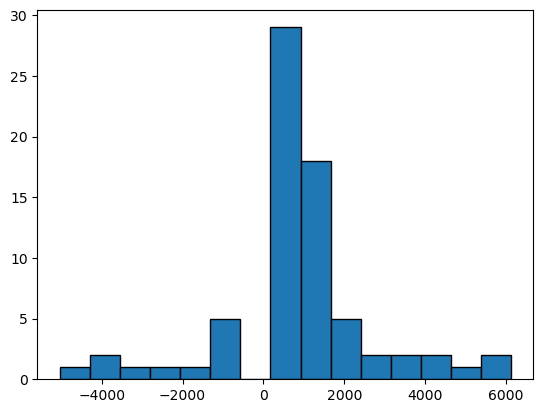

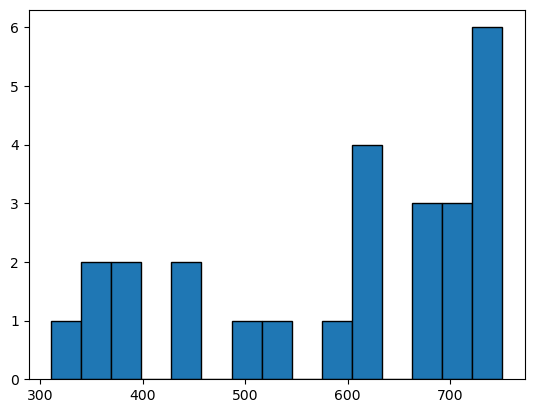

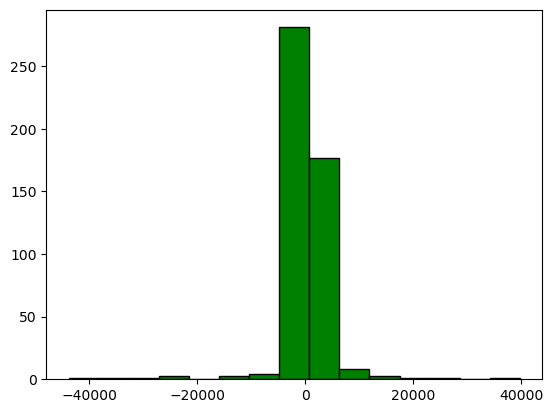

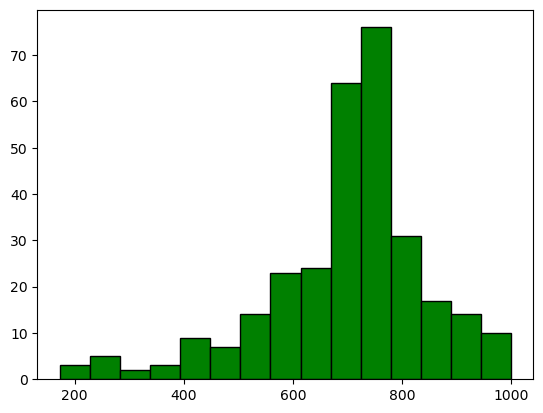

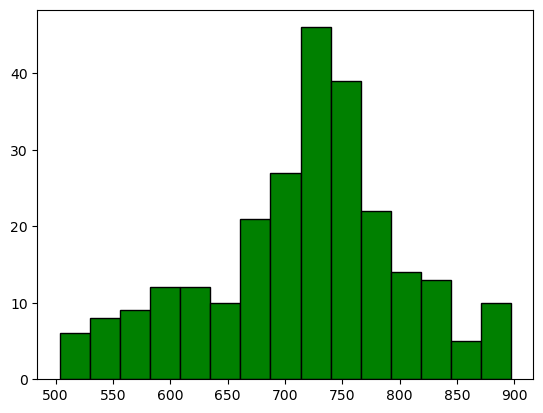

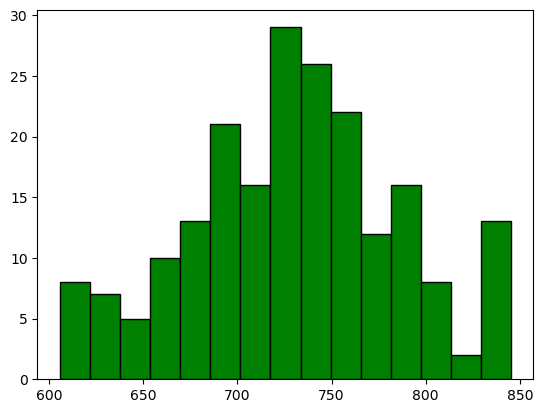

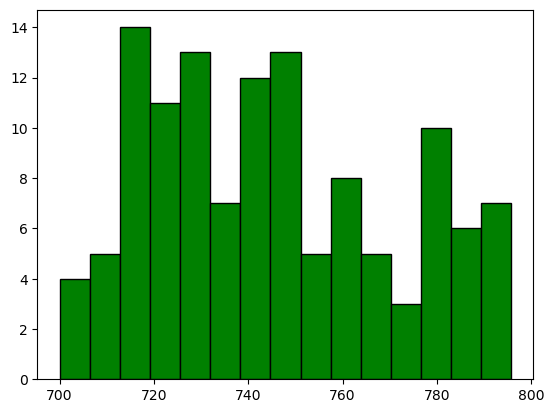

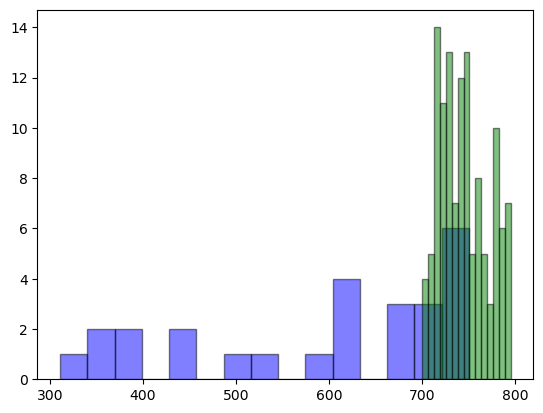

In [15]:
#different SOUTH plot display
# gaia Distance Histogram
parallax_aS = gaiaS_data['parallax'] / 1000
distances_pcS = 1 / parallax_aS
plt.hist(distances_pcS, bins = 15, edgecolor='black')
plt.show()

# Filtering outliers
filtered_distancesS = [dist for dist in distances_pcS if 0 < dist < 800]
distances_bluesS = [abs(dist) for dist in filtered_distancesS]
len(distances_bluesS)
plt.hist(distances_bluesS, bins = 15, edgecolor='black')
plt.show()


#  shared Distance Histogram
parallax_aS = sharedS_data['parallax'] / 1000
distances_pcS = 1 / parallax_aS
plt.hist(distances_pcS, bins = 15, color='green', edgecolor='black')
plt.show()

# Filtering  outliers
filtered_distancesS = [dist for dist in distances_pcS if 0 < dist < 1000]
distances_greensSS = [abs(dist) for dist in filtered_distancesS]
len(distances_greensSS)
plt.hist(distances_greensSS, bins = 15, color='green', edgecolor='black')
plt.show()

# Filtering  outliers
filtered_distancesS = [dist for dist in distances_pcS if 500 < dist < 900]
distances_greensS = [abs(dist) for dist in filtered_distancesS]
len(distances_greensS)
plt.hist(distances_greensS, bins = 15, color='green', edgecolor='black')
plt.show()

# Filtering  outliers
filtered_distancesS = [dist for dist in distances_pcS if 600 < dist < 850]
distances_greensS = [abs(dist) for dist in filtered_distancesS]
len(distances_greensS)
plt.hist(distances_greensS, bins = 15, color='green', edgecolor='black')
plt.show()

# Filtering  outliers
filtered_distancesS = [dist for dist in distances_pcS if 700 < dist < 800]
distances_greensS = [abs(dist) for dist in filtered_distancesS]
len(distances_greensS)
plt.hist(distances_greensS, bins = 15, color='green', edgecolor='black')
plt.show()



# # Overlaying Histograms
plt.hist(distances_bluesS, bins=15, alpha=0.5, color='blue', edgecolor='black')
plt.hist(distances_greensS, bins=15, alpha=0.5, color='green', edgecolor='black')
plt.show()

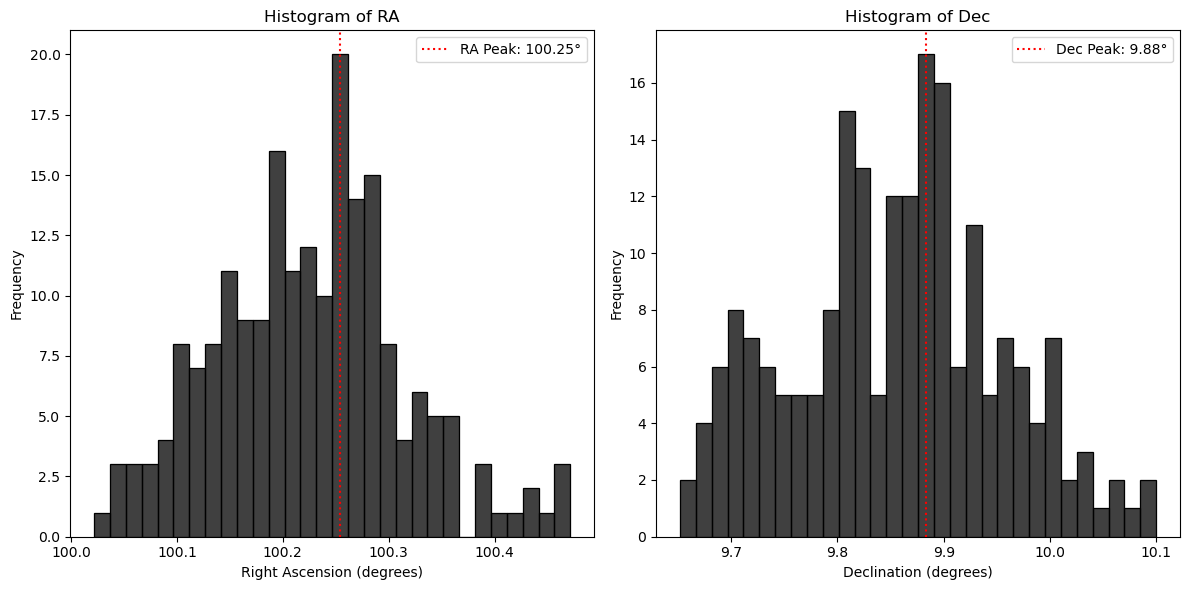

In [16]:

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

filtered_gaia = gaia_v2[(gaia_v2['distance'] >= 680) & (gaia_v2['distance'] <= 760)]

hist_ra, bins_ra = np.histogram(filtered_gaia['ra'], bins=30)
bin_centers_ra = (bins_ra[:-1] + bins_ra[1:]) / 2  # Calculate bin centers
peak_ra = bin_centers_ra[np.argmax(hist_ra)]  # Find the bin center with the highest count


sns.histplot(filtered_gaia['ra'], bins=30, kde=False, ax=axes[0], color='black')
axes[0].set_title('Histogram of RA')
axes[0].set_xlabel('Right Ascension (degrees)')
axes[0].set_ylabel('Frequency')


axes[0].axvline(peak_ra, color='red', linestyle=':', label=f'RA Peak: {peak_ra:.2f}°')
axes[0].legend()


hist_dec, bins_dec = np.histogram(filtered_gaia['dec'], bins=30)
bin_centers_dec = (bins_dec[:-1] + bins_dec[1:]) / 2  # Calculate bin centers
peak_dec = bin_centers_dec[np.argmax(hist_dec)]  # Find the bin center with the highest count

# Plot the histogram for Dec
sns.histplot(filtered_gaia['dec'], bins=30, kde=False, ax=axes[1], color='black')
axes[1].set_title('Histogram of Dec')
axes[1].set_xlabel('Declination (degrees)')
axes[1].set_ylabel('Frequency')

# Add red dotted line at the peak
axes[1].axvline(peak_dec, color='red', linestyle=':', label=f'Dec Peak: {peak_dec:.2f}°')
axes[1].legend()

# Display the plots
plt.tight_layout()
plt.show()


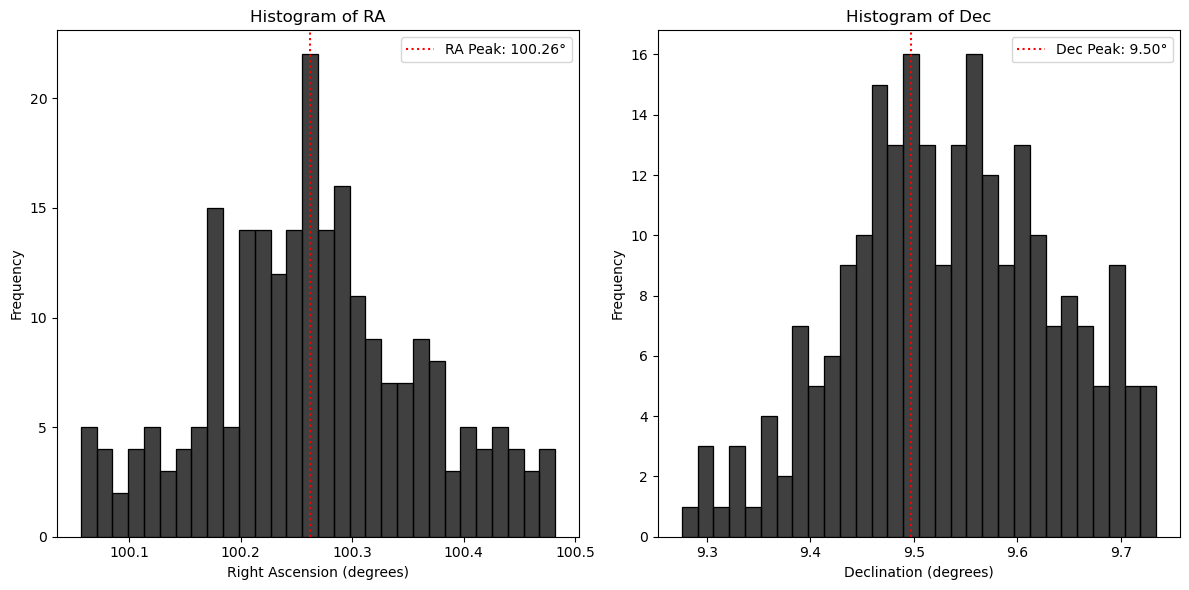

In [17]:

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

filtered_gaia = gaia1[(gaia1['distance'] >= 680) & (gaia1['distance'] <= 790)]

hist_ra, bins_ra = np.histogram(filtered_gaia['ra'], bins=30)
bin_centers_ra = (bins_ra[:-1] + bins_ra[1:]) / 2  # Calculate bin centers
peak_ra = bin_centers_ra[np.argmax(hist_ra)]  # Find the bin center with the highest count


sns.histplot(filtered_gaia['ra'], bins=30, kde=False, ax=axes[0], color='black')
axes[0].set_title('Histogram of RA')
axes[0].set_xlabel('Right Ascension (degrees)')
axes[0].set_ylabel('Frequency')


axes[0].axvline(peak_ra, color='red', linestyle=':', label=f'RA Peak: {peak_ra:.2f}°')
axes[0].legend()


hist_dec, bins_dec = np.histogram(filtered_gaia['dec'], bins=30)
bin_centers_dec = (bins_dec[:-1] + bins_dec[1:]) / 2  # Calculate bin centers
peak_dec = bin_centers_dec[np.argmax(hist_dec)]  # Find the bin center with the highest count

# Plot the histogram for Dec
sns.histplot(filtered_gaia['dec'], bins=30, kde=False, ax=axes[1], color='black')
axes[1].set_title('Histogram of Dec')
axes[1].set_xlabel('Declination (degrees)')
axes[1].set_ylabel('Frequency')

# Add red dotted line at the peak
axes[1].axvline(peak_dec, color='red', linestyle=':', label=f'Dec Peak: {peak_dec:.2f}°')
axes[1].legend()

# Display the plots
plt.tight_layout()
plt.show()


In [18]:
def fetch_and_filter_gaia_data1(ra, dec, radius=0.5):
    # Define coordinates
    coord = SkyCoord(ra=ra, dec=dec, unit=(u.degree, u.degree), frame='icrs')
    
    # Perform cone search
    job = Gaia.cone_search_async(coord, radius=u.Quantity(radius, u.deg))
    results = job.get_results()
    
    # Convert to pandas DataFrame
    gaia_df = results.to_pandas()
    
    # Drop rows with NaN values in 'parallax' column
    gaia_df = gaia_df.dropna(subset=['parallax'])
    
    # Create a new DataFrame for calculations
    filtered_df = gaia_df.copy()
    
    # Calculate distance from parallax
    filtered_df['distance'] = 1 / ((10**-3) * abs(filtered_df['parallax']))
    
    filtered_df = filtered_df[filtered_df['parallax_error'] <= 0.3]
    
    return filtered_df.reset_index(drop=True)

# Usage
onc_ra1 = 100.35  # degrees
onc_dec1 = 9.80
gaia3 = fetch_and_filter_gaia_data1(onc_ra1, onc_dec1)
print(gaia3)

INFO: Query finished. [astroquery.utils.tap.core]
              solution_id                   DESIGNATION            SOURCE_ID  \
0     1635721458409799680  Gaia DR2 3326735642890749440  3326735642890749440   
1     1635721458409799680  Gaia DR2 3326736394509695872  3326736394509695872   
2     1635721458409799680  Gaia DR2 3326735535516233216  3326735535516233216   
3     1635721458409799680  Gaia DR2 3326735535516232704  3326735535516232704   
4     1635721458409799680  Gaia DR2 3326736394509696128  3326736394509696128   
...                   ...                           ...                  ...   
6669  1635721458409799680  Gaia DR2 3350752923915886208  3350752923915886208   
6670  1635721458409799680  Gaia DR2 3326606484634522112  3326606484634522112   
6671  1635721458409799680  Gaia DR2 3350771100218250240  3350771100218250240   
6672  1635721458409799680  Gaia DR2 3326950425615575680  3326950425615575680   
6673  1635721458409799680  Gaia DR2 3326633319590315392  3326633319590

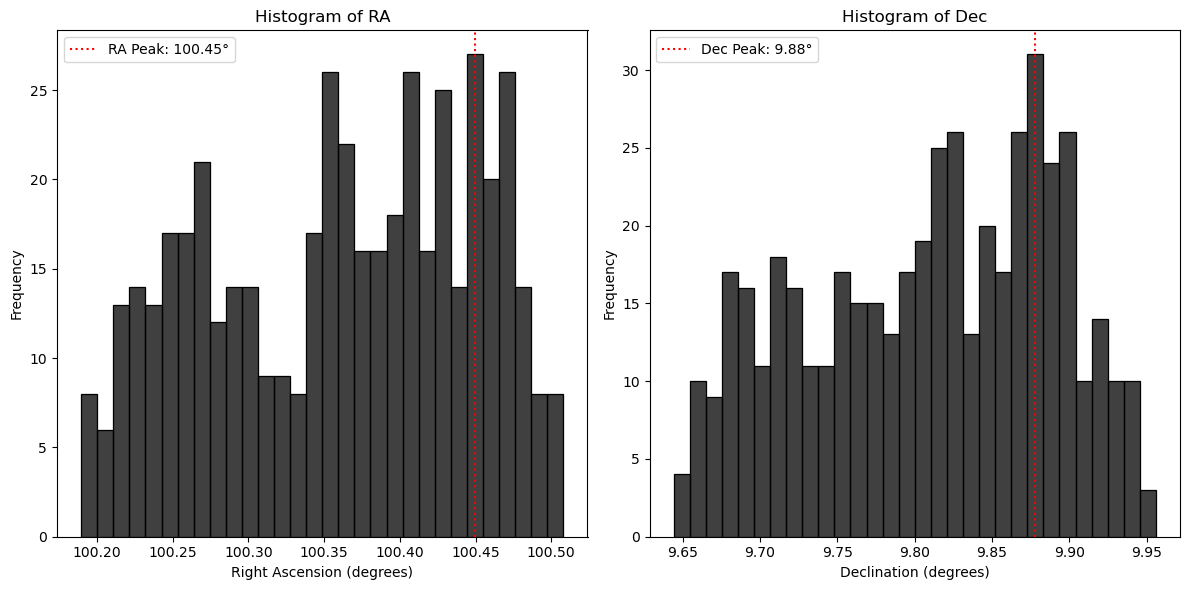

In [19]:

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

filtered_gaia = gaia3[(gaia3['distance'] >= 500) & (gaia1['distance'] <= 850)]

hist_ra, bins_ra = np.histogram(filtered_gaia['ra'], bins=30)
bin_centers_ra = (bins_ra[:-1] + bins_ra[1:]) / 2  # Calculate bin centers
peak_ra = bin_centers_ra[np.argmax(hist_ra)]  # Find the bin center with the highest count


sns.histplot(filtered_gaia['ra'], bins=30, kde=False, ax=axes[0], color='black')
axes[0].set_title('Histogram of RA')
axes[0].set_xlabel('Right Ascension (degrees)')
axes[0].set_ylabel('Frequency')


axes[0].axvline(peak_ra, color='red', linestyle=':', label=f'RA Peak: {peak_ra:.2f}°')
axes[0].legend()


hist_dec, bins_dec = np.histogram(filtered_gaia['dec'], bins=30)
bin_centers_dec = (bins_dec[:-1] + bins_dec[1:]) / 2  # Calculate bin centers
peak_dec = bin_centers_dec[np.argmax(hist_dec)]  # Find the bin center with the highest count

# Plot the histogram for Dec
sns.histplot(filtered_gaia['dec'], bins=30, kde=False, ax=axes[1], color='black')
axes[1].set_title('Histogram of Dec')
axes[1].set_xlabel('Declination (degrees)')
axes[1].set_ylabel('Frequency')

# Add red dotted line at the peak
axes[1].axvline(peak_dec, color='red', linestyle=':', label=f'Dec Peak: {peak_dec:.2f}°')
axes[1].legend()

# Display the plots
plt.tight_layout()
plt.show()

In [20]:
SIMBAD_ra1 = 100.50
SIMBAD_dec1 = 9.80
surv_ra = SIMBAD_ra1 + 0.00138889 #5''
surv_dec = SIMBAD_dec1 + 0.00138889

# Prepare the query
query = f"""
    SELECT ra, dec, j_m, j_msigcom, h_m, h_msigcom, k_m, k_msigcom, ph_qual, cc_flg
    FROM fp_psc
    WHERE CONTAINS(POINT('ICRS', ra, dec), CIRCLE('ICRS', {surv_ra}, {surv_dec}, 0.36)) = 1
"""

# Access the TAP service and run the query
service = pyvo.dal.TAPService('https://irsa.ipac.caltech.edu/TAP')
result = service.run_async(query)

# Handle the result
try:
    TwoMASST = result.to_table()
    print(TwoMASST)
    
    # Making necessary 4 lists
    ra_G = gaia3['ra'].tolist()  # Replace 'df' with your Gaia DataFrame if needed
    dec_G = gaia3['dec'].tolist()  # Replace 'df' with your Gaia DataFrame if needed
    ra_TM = TwoMASST['ra'].tolist()
    dec_TM = TwoMASST['dec'].tolist()
    
except Exception as e:
    print(f"An error occurred: {e}")

    ra        dec     j_m   j_msigcom  h_m   ...  k_m   k_msigcom ph_qual cc_flg
   deg        deg     mag      mag     mag   ...  mag      mag                  
---------- --------- ------ --------- ------ ... ------ --------- ------- ------
100.227487 10.002212 16.110     0.116 15.342 ... 14.867     0.139     BAB    000
100.216100  9.999519 16.598     0.174 15.762 ... 15.184     0.177     CBC    000
100.219236 10.006597 16.958     0.226 15.858 ... 15.384     0.193     DBC    000
100.226710 10.013842 15.637     0.071 15.026 ... 14.846     0.143     AAB    000
100.223540 10.019098 16.273     0.129 15.816 ... 15.042     0.162     BBC    000
100.226366 10.021400 15.654     0.066 14.857 ... 14.678     0.119     AAB    000
100.213983 10.018983 16.251     0.128 15.495 ... 14.946     0.138     BAB    000
100.209572 10.017871 13.423     0.027 12.751 ... 12.495     0.026     AAA    000
100.217131 10.014064 15.572     0.069 15.118 ... 14.721     0.122     AAB    000
       ...       ...    ... 

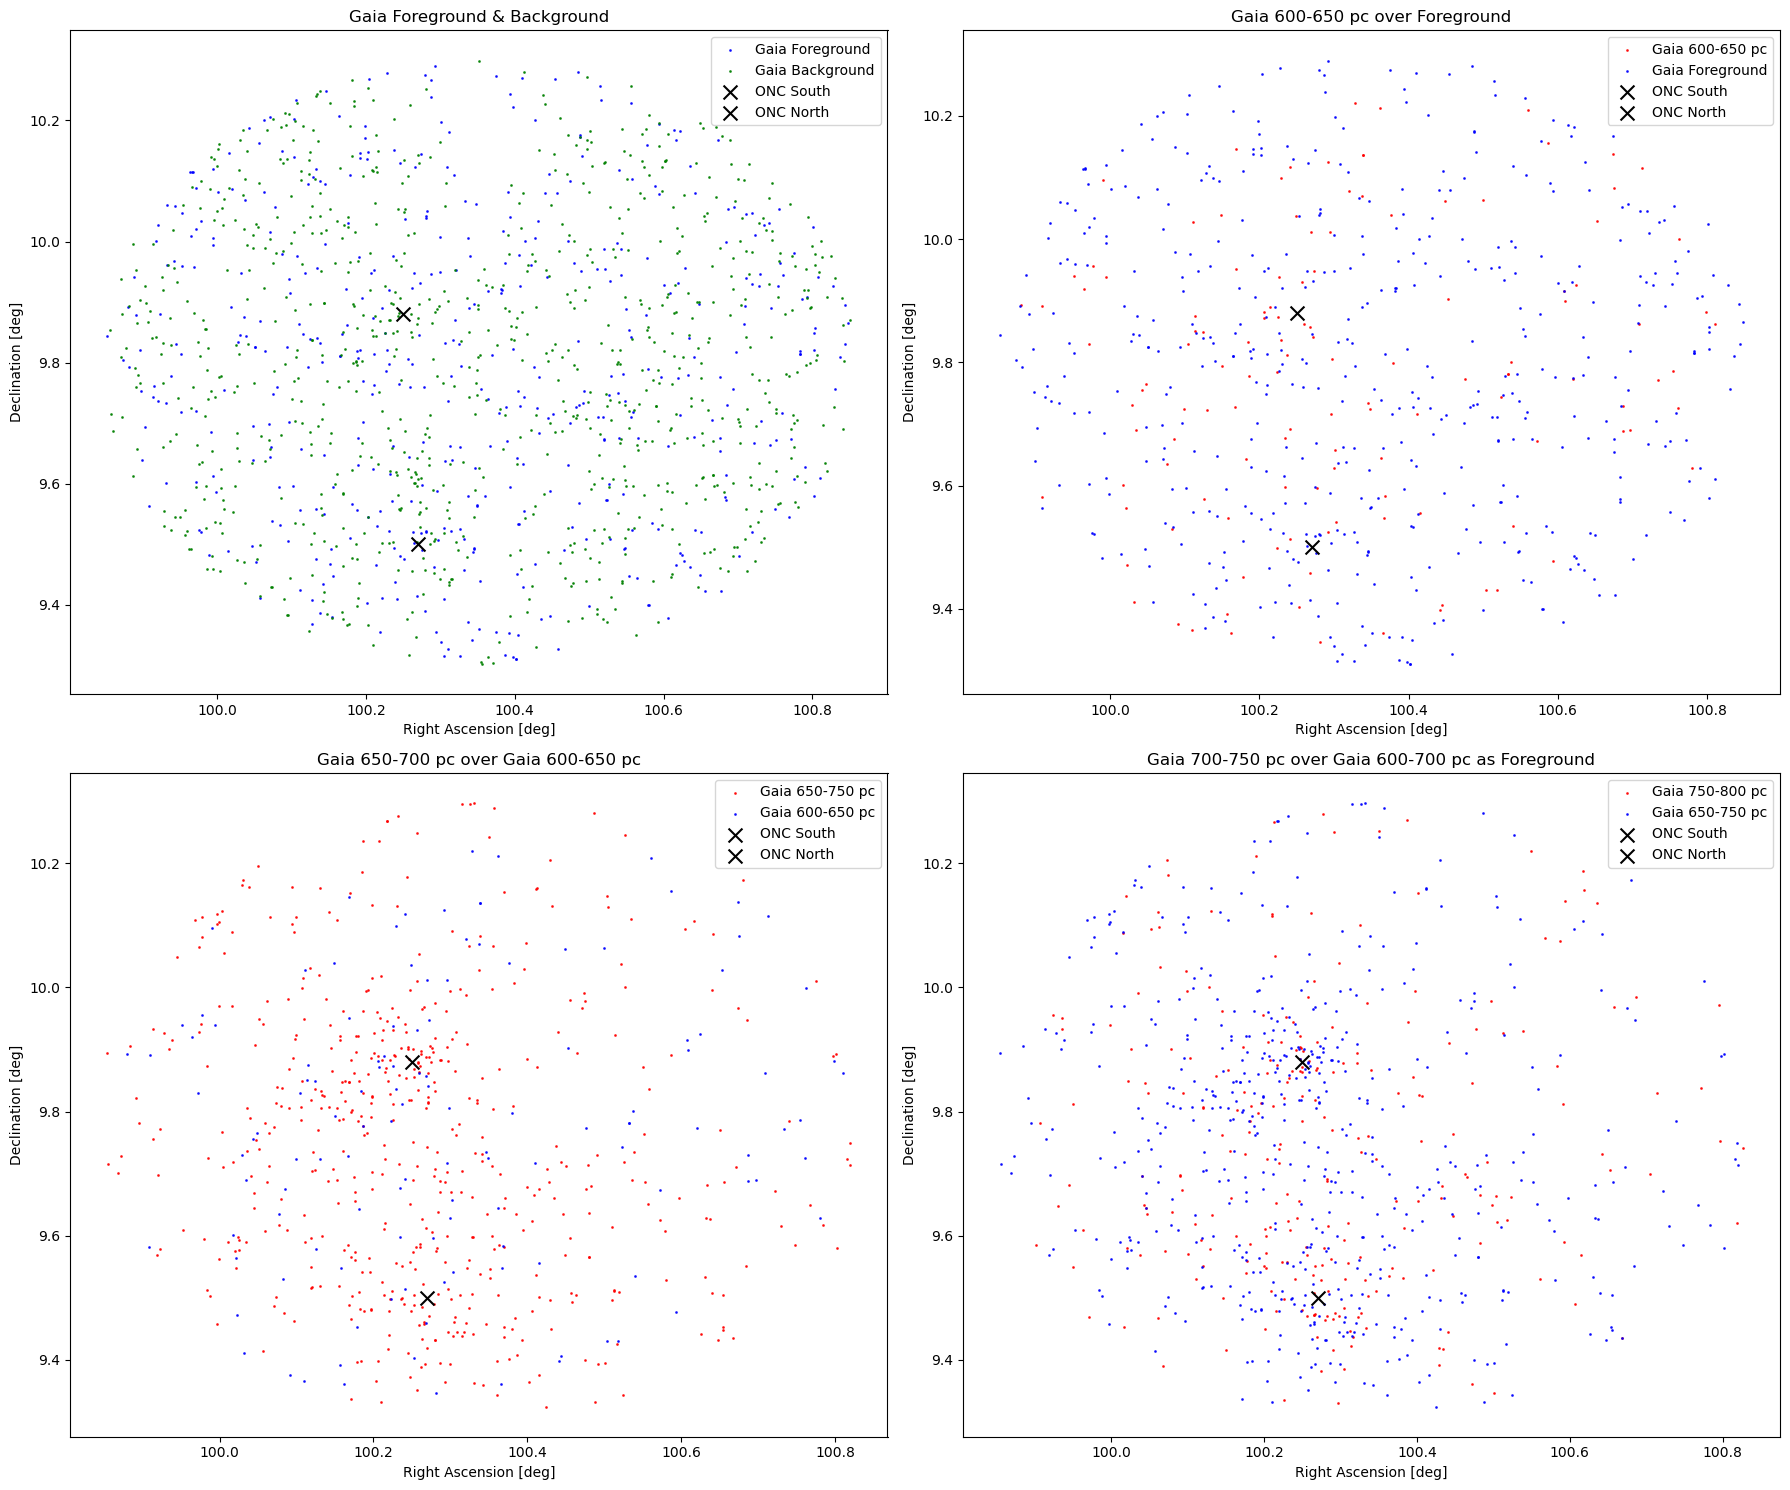

In [21]:

gaia3_ra = gaia3['ra']
gaia3_dec = gaia3['dec']
TwoMASST_ra = TwoMASST['ra']
TwoMASST_dec = TwoMASST['dec']

onc_ra = 100.27  # South
onc_dec = 9.50
onc_ra1 = 100.25  # North
onc_dec1 = 9.88

gaia_foreground = gaia3[(gaia3['distance'] >= 0) & (gaia3['distance'] <= 600)]
gaia_background = gaia3[(gaia3['distance'] >= 800) & (gaia3['distance'] <= 1300)]
gaia_2= gaia3[(gaia3['distance'] >= 600) & (gaia3['distance'] <= 650)]
gaia_3= gaia3[(gaia3['distance'] >= 650) & (gaia3['distance'] <= 750)]
gaia_4= gaia3[(gaia3['distance'] >= 750) & (gaia3['distance'] <= 800)]
gaia_4_1= gaia3[(gaia3['distance'] >= 650) & (gaia3['distance'] <= 750)]

# Create subplots
fig, axs = plt.subplots(2, 2, figsize=(18, 15))

# Plot 1: Gaia Foreground
axs[0, 0].scatter(gaia_foreground['ra'], gaia_foreground['dec'], s=1, color='blue', label='Gaia Foreground', alpha=0.8)
axs[0, 0].scatter(gaia_background['ra'], gaia_background['dec'], s=1, color='green', label='Gaia Background', alpha=0.8)
axs[0, 0].scatter(onc_ra, onc_dec, color='black', marker='x', s=100, label='ONC South')
axs[0, 0].scatter(onc_ra1, onc_dec1, color='black', marker='x', s=100, label='ONC North')
axs[0, 0].set_title('Gaia Foreground & Background')
axs[0, 0].set_xlabel('Right Ascension [deg]')
axs[0, 0].set_ylabel('Declination [deg]')
axs[0, 0].legend()

# Plot 2: Gaia Background
axs[0, 1].scatter(gaia_2['ra'], gaia_2['dec'], s=1, color='red', label='Gaia 600-650 pc', alpha=0.8)
axs[0, 1].scatter(gaia_foreground['ra'], gaia_foreground['dec'], s=1, color='blue', label='Gaia Foreground', alpha=0.8)
axs[0, 1].scatter(onc_ra, onc_dec, color='black', marker='x', s=100, label='ONC South')
axs[0, 1].scatter(onc_ra1, onc_dec1, color='black', marker='x', s=100, label='ONC North')
axs[0, 1].set_title('Gaia 600-650 pc over Foreground')
axs[0, 1].set_xlabel('Right Ascension [deg]')
axs[0, 1].set_ylabel('Declination [deg]')
axs[0, 1].legend()

# Plot 3: TwoMASST Data
axs[1, 0].scatter(gaia_3['ra'], gaia_3['dec'], s=1, color='red', label='Gaia 650-750 pc', alpha=0.8)
axs[1, 0].scatter(gaia_2['ra'], gaia_2['dec'], s=1, color='blue', label='Gaia 600-650 pc', alpha=0.8)
axs[1, 0].scatter(onc_ra, onc_dec, color='black', marker='x', s=100, label='ONC South')
axs[1, 0].scatter(onc_ra1, onc_dec1, color='black', marker='x', s=100, label='ONC North')
axs[1, 0].set_title('Gaia 650-700 pc over Gaia 600-650 pc')
axs[1, 0].set_xlabel('Right Ascension [deg]')
axs[1, 0].set_ylabel('Declination [deg]')
axs[1, 0].legend()

# Plot 4: Combined Data
axs[1, 1].scatter(gaia_4['ra'], gaia_4['dec'], s=1, color='red', label='Gaia 750-800 pc', alpha=0.8)
axs[1, 1].scatter(gaia_4_1['ra'], gaia_4_1['dec'], s=1, color='blue', label='Gaia 650-750 pc', alpha=0.8)
axs[1, 1].scatter(onc_ra, onc_dec, color='black', marker='x', s=100, label='ONC South')
axs[1, 1].scatter(onc_ra1, onc_dec1, color='black', marker='x', s=100, label='ONC North')
axs[1, 1].set_title('Gaia 700-750 pc over Gaia 600-700 pc as Foreground')
axs[1, 1].set_xlabel('Right Ascension [deg]')
axs[1, 1].set_ylabel('Declination [deg]')
axs[1, 1].legend()

plt.tight_layout()
plt.show()


#Literature says NGC 2264 is between 760 pc +/- 85, Marinas article states she used 780 pc


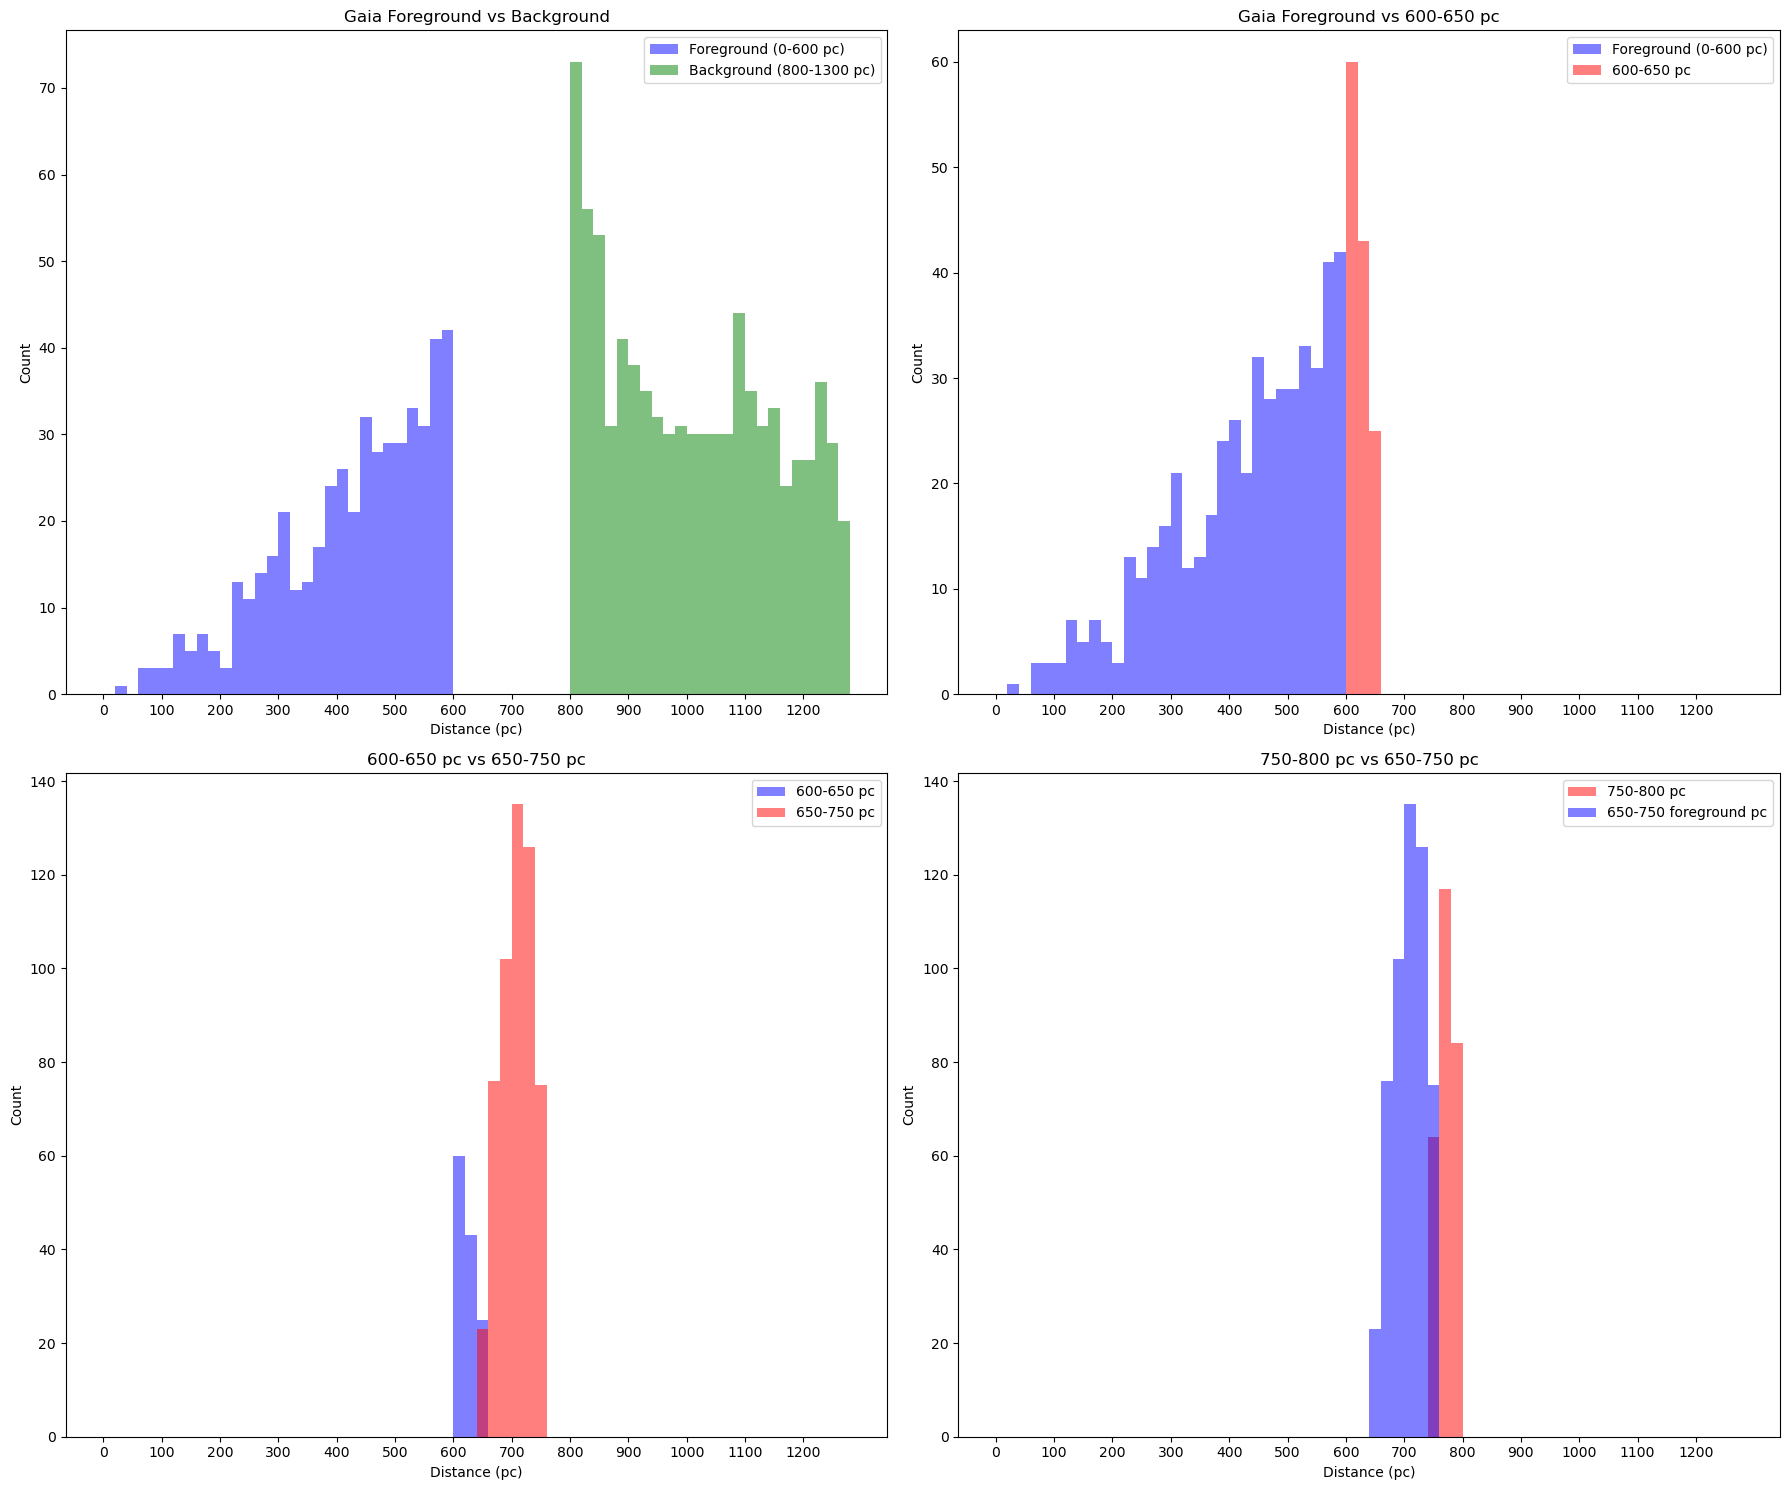

In [22]:
import matplotlib.pyplot as plt
import numpy as np

# Define the bins (100 pc increment)
bins = np.arange(0, 1300, 20)  # Range from 0 to 1500 pc with steps of 100 pc

# Create subplots
fig, axs = plt.subplots(2, 2, figsize=(18, 15))

# Plot 1: Gaia Foreground vs Background
axs[0, 0].hist(gaia_foreground['distance'], bins=bins, color='blue', alpha=0.5, label='Foreground (0-600 pc)')
axs[0, 0].hist(gaia_background['distance'], bins=bins, color='green', alpha=0.5, label='Background (800-1300 pc)')
axs[0, 0].set_title('Gaia Foreground vs Background')
axs[0, 0].set_xlabel('Distance (pc)')
axs[0, 0].set_ylabel('Count')
axs[0, 0].legend()

# Set x-axis ticks in increments of 100 pc
axs[0, 0].set_xticks(np.arange(0, 1300, 100))

# Plot 2: Gaia Foreground vs Gaia 600-650 pc
axs[0, 1].hist(gaia_foreground['distance'], bins=bins, color='blue', alpha=0.5, label='Foreground (0-600 pc)')
axs[0, 1].hist(gaia_2['distance'], bins=bins, color='red', alpha=0.5, label='600-650 pc')
axs[0, 1].set_title('Gaia Foreground vs 600-650 pc')
axs[0, 1].set_xlabel('Distance (pc)')
axs[0, 1].set_ylabel('Count')
axs[0, 1].legend()

# Set x-axis ticks in increments of 100 pc
axs[0, 1].set_xticks(np.arange(0, 1300, 100))

# Plot 3: Gaia 600-650 pc vs 650-750 pc
axs[1, 0].hist(gaia_2['distance'], bins=bins, color='blue', alpha=0.5, label='600-650 pc')
axs[1, 0].hist(gaia_3['distance'], bins=bins, color='red', alpha=0.5, label='650-750 pc')
axs[1, 0].set_title('600-650 pc vs 650-750 pc')
axs[1, 0].set_xlabel('Distance (pc)')
axs[1, 0].set_ylabel('Count')
axs[1, 0].legend()

# Set x-axis ticks in increments of 100 pc
axs[1, 0].set_xticks(np.arange(0, 1300, 100))

# Plot 4: Gaia 750-800 pc vs 650-750 pc
axs[1, 1].hist(gaia_4['distance'], bins=bins, color='red', alpha=0.5, label='750-800 pc')
axs[1, 1].hist(gaia_4_1['distance'], bins=bins, color='blue', alpha=0.5, label='650-750 foreground pc')
axs[1, 1].set_title('750-800 pc vs 650-750 pc')
axs[1, 1].set_xlabel('Distance (pc)')
axs[1, 1].set_ylabel('Count')
axs[1, 1].legend()

# Set x-axis ticks in increments of 100 pc
axs[1, 1].set_xticks(np.arange(0, 1300, 100))

# Adjust layout and show the plots
plt.tight_layout()
plt.show()


#This display shows the peak is around 700 for NGC 2264


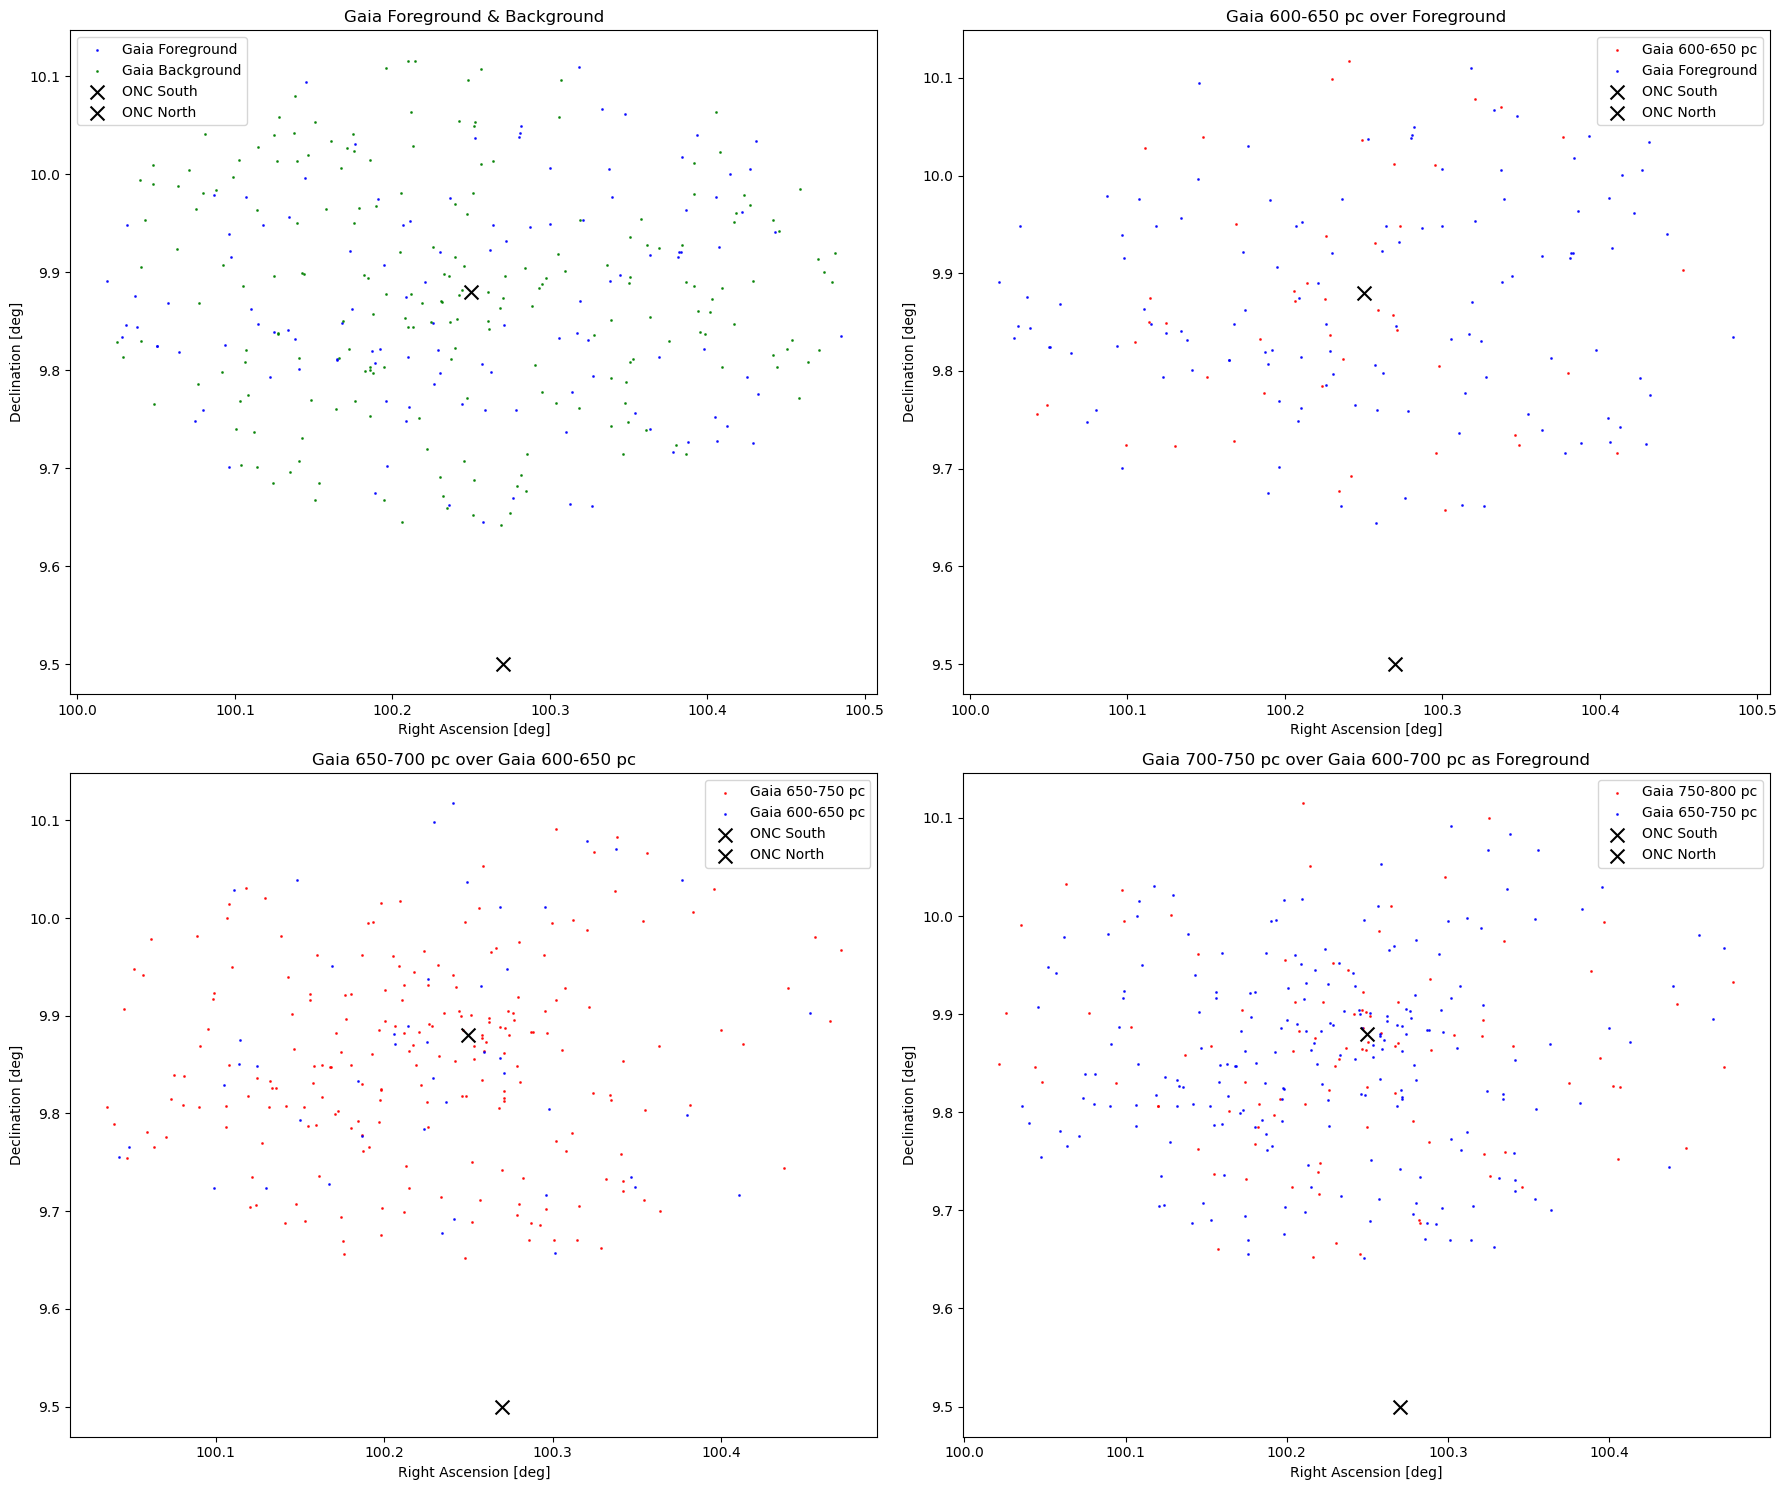

In [23]:
#North ! 


gaiaN_ra = gaia_v2['ra']
gaiaN_dec = gaia_v2['dec']
TwoMASS_ra = TwoMASS['ra']
TwoMASS_dec = TwoMASS['dec']

gaia_foreground = gaia_v2[(gaia_v2['distance'] >= 0) & (gaia_v2['distance'] <= 600)]
gaia_background = gaia_v2[(gaia_v2['distance'] >= 800) & (gaia_v2['distance'] <= 1300)]
gaia_2= gaia_v2[(gaia_v2['distance'] >= 600) & (gaia_v2['distance'] <= 650)]
gaia_3= gaia_v2[(gaia_v2['distance'] >= 650) & (gaia_v2['distance'] <= 750)]
gaia_4= gaia_v2[(gaia_v2['distance'] >= 750) & (gaia_v2['distance'] <= 800)]
gaia_4_1= gaia_v2[(gaia_v2['distance'] >= 650) & (gaia_v2['distance'] <= 750)]

# Create subplots
fig, axs = plt.subplots(2, 2, figsize=(18, 15))

# Plot 1: Gaia Foreground
axs[0, 0].scatter(gaia_foreground['ra'], gaia_foreground['dec'], s=1, color='blue', label='Gaia Foreground', alpha=0.8)
axs[0, 0].scatter(gaia_background['ra'], gaia_background['dec'], s=1, color='green', label='Gaia Background', alpha=0.8)
axs[0, 0].scatter(onc_ra, onc_dec, color='black', marker='x', s=100, label='ONC South')
axs[0, 0].scatter(onc_ra1, onc_dec1, color='black', marker='x', s=100, label='ONC North')
axs[0, 0].set_title('Gaia Foreground & Background')
axs[0, 0].set_xlabel('Right Ascension [deg]')
axs[0, 0].set_ylabel('Declination [deg]')
axs[0, 0].legend()

# Plot 2: Gaia Background
axs[0, 1].scatter(gaia_2['ra'], gaia_2['dec'], s=1, color='red', label='Gaia 600-650 pc', alpha=0.8)
axs[0, 1].scatter(gaia_foreground['ra'], gaia_foreground['dec'], s=1, color='blue', label='Gaia Foreground', alpha=0.8)
axs[0, 1].scatter(onc_ra, onc_dec, color='black', marker='x', s=100, label='ONC South')
axs[0, 1].scatter(onc_ra1, onc_dec1, color='black', marker='x', s=100, label='ONC North')
axs[0, 1].set_title('Gaia 600-650 pc over Foreground')
axs[0, 1].set_xlabel('Right Ascension [deg]')
axs[0, 1].set_ylabel('Declination [deg]')
axs[0, 1].legend()

# Plot 3: TwoMASST Data
axs[1, 0].scatter(gaia_3['ra'], gaia_3['dec'], s=1, color='red', label='Gaia 650-750 pc', alpha=0.8)
axs[1, 0].scatter(gaia_2['ra'], gaia_2['dec'], s=1, color='blue', label='Gaia 600-650 pc', alpha=0.8)
axs[1, 0].scatter(onc_ra, onc_dec, color='black', marker='x', s=100, label='ONC South')
axs[1, 0].scatter(onc_ra1, onc_dec1, color='black', marker='x', s=100, label='ONC North')
axs[1, 0].set_title('Gaia 650-700 pc over Gaia 600-650 pc')
axs[1, 0].set_xlabel('Right Ascension [deg]')
axs[1, 0].set_ylabel('Declination [deg]')
axs[1, 0].legend()

# Plot 4: Combined Data
axs[1, 1].scatter(gaia_4['ra'], gaia_4['dec'], s=1, color='red', label='Gaia 750-800 pc', alpha=0.8)
axs[1, 1].scatter(gaia_4_1['ra'], gaia_4_1['dec'], s=1, color='blue', label='Gaia 650-750 pc', alpha=0.8)
axs[1, 1].scatter(onc_ra, onc_dec, color='black', marker='x', s=100, label='ONC South')
axs[1, 1].scatter(onc_ra1, onc_dec1, color='black', marker='x', s=100, label='ONC North')
axs[1, 1].set_title('Gaia 700-750 pc over Gaia 600-700 pc as Foreground')
axs[1, 1].set_xlabel('Right Ascension [deg]')
axs[1, 1].set_ylabel('Declination [deg]')
axs[1, 1].legend()

plt.tight_layout()
plt.show()

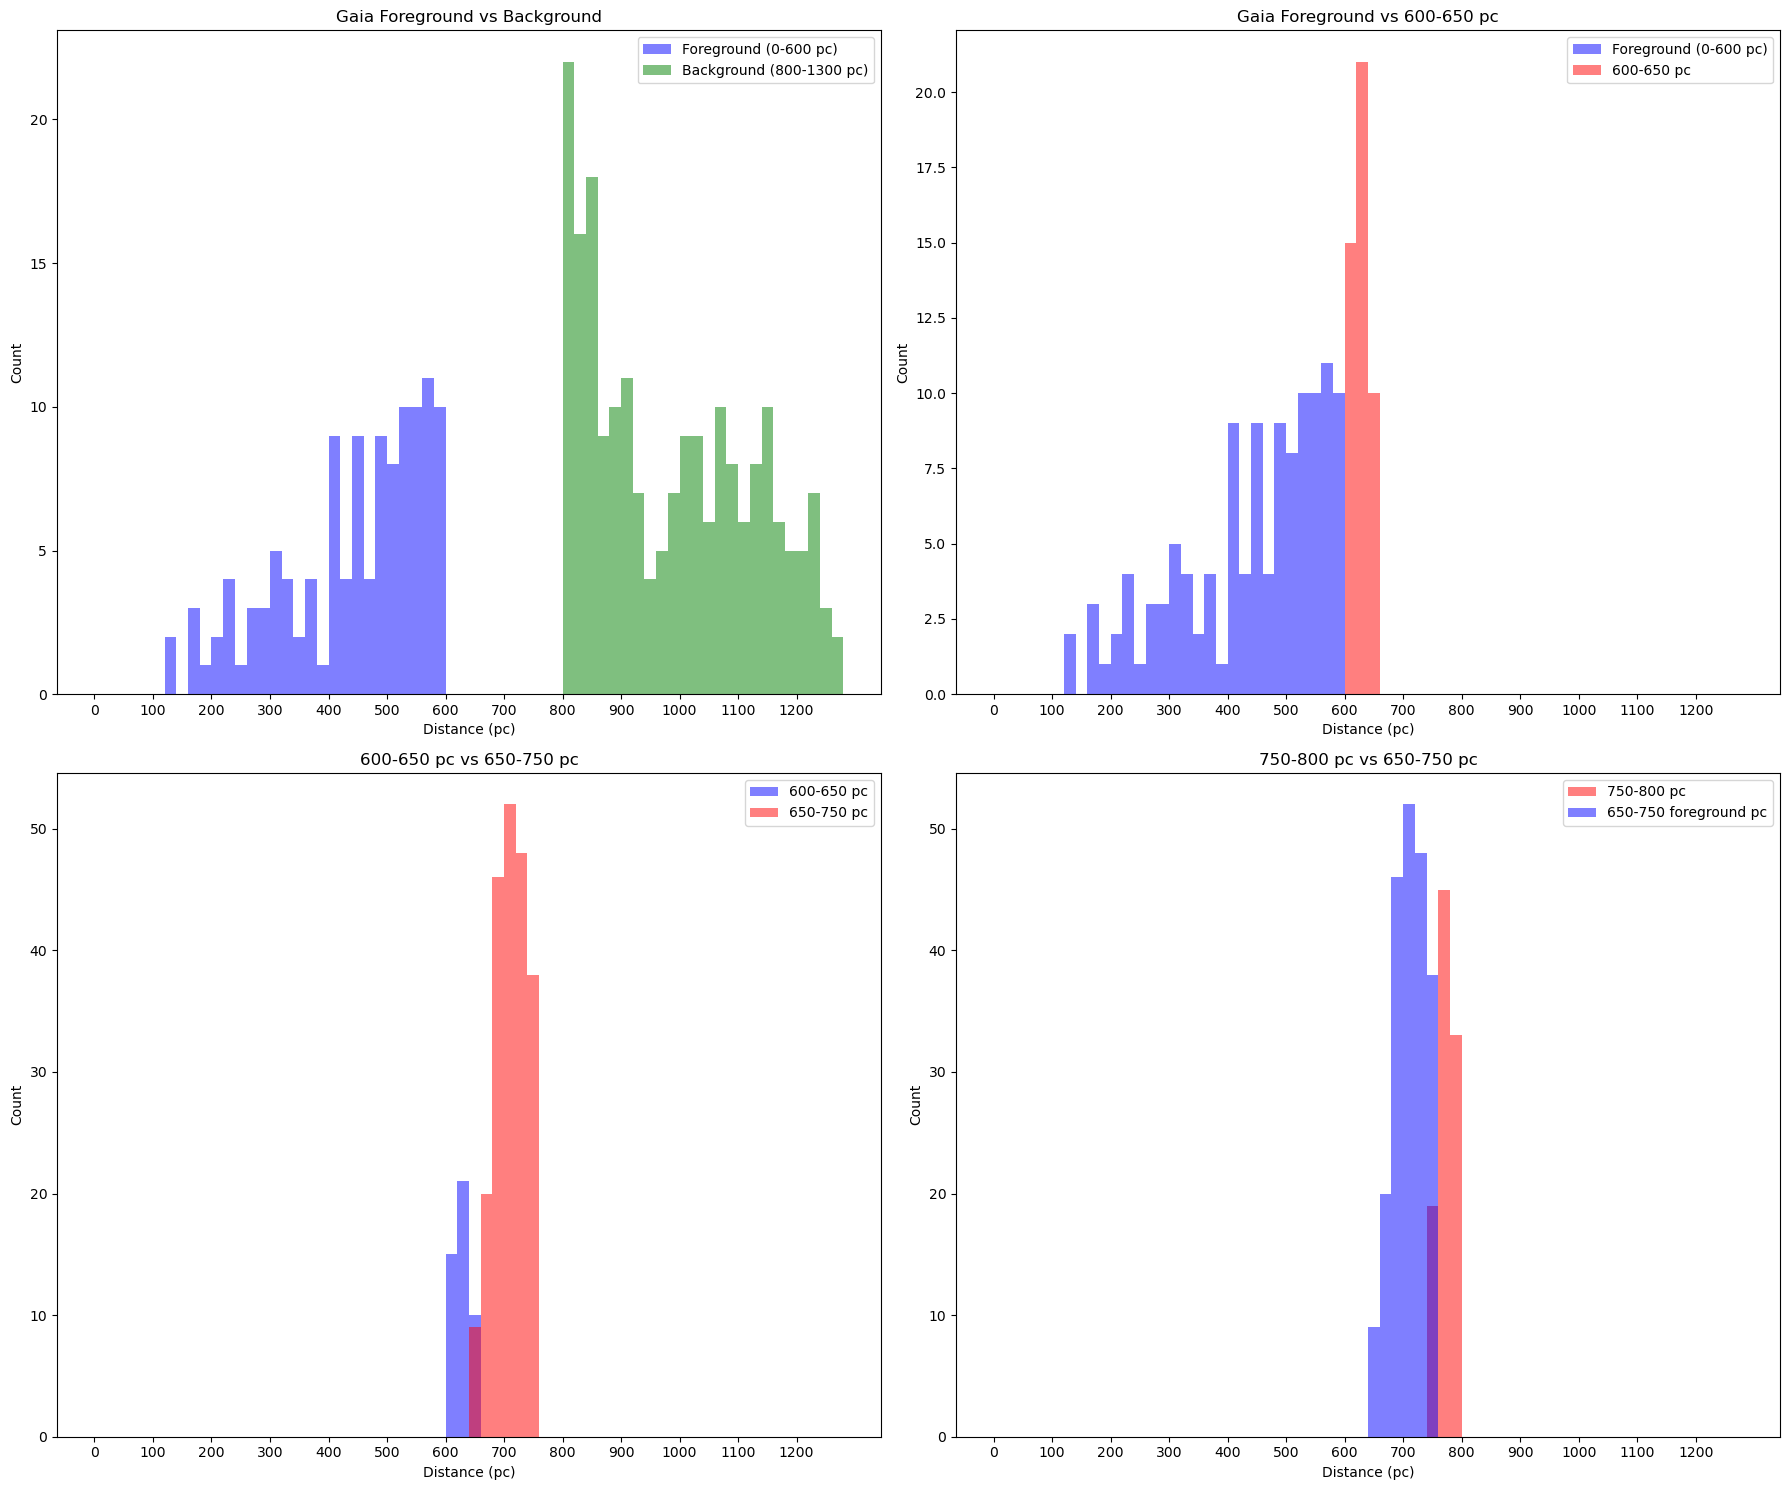

In [24]:

# Define the bins (100 pc increment)
bins = np.arange(0, 1300, 20)  # Range from 0 to 1500 pc with steps of 100 pc

# Create subplots
fig, axs = plt.subplots(2, 2, figsize=(18, 15))

# Plot 1: Gaia Foreground vs Background
axs[0, 0].hist(gaia_foreground['distance'], bins=bins, color='blue', alpha=0.5, label='Foreground (0-600 pc)')
axs[0, 0].hist(gaia_background['distance'], bins=bins, color='green', alpha=0.5, label='Background (800-1300 pc)')
axs[0, 0].set_title('Gaia Foreground vs Background')
axs[0, 0].set_xlabel('Distance (pc)')
axs[0, 0].set_ylabel('Count')
axs[0, 0].legend()

# Set x-axis ticks in increments of 100 pc
axs[0, 0].set_xticks(np.arange(0, 1300, 100))

# Plot 2: Gaia Foreground vs Gaia 600-650 pc
axs[0, 1].hist(gaia_foreground['distance'], bins=bins, color='blue', alpha=0.5, label='Foreground (0-600 pc)')
axs[0, 1].hist(gaia_2['distance'], bins=bins, color='red', alpha=0.5, label='600-650 pc')
axs[0, 1].set_title('Gaia Foreground vs 600-650 pc')
axs[0, 1].set_xlabel('Distance (pc)')
axs[0, 1].set_ylabel('Count')
axs[0, 1].legend()

# Set x-axis ticks in increments of 100 pc
axs[0, 1].set_xticks(np.arange(0, 1300, 100))

# Plot 3: Gaia 600-650 pc vs 650-750 pc
axs[1, 0].hist(gaia_2['distance'], bins=bins, color='blue', alpha=0.5, label='600-650 pc')
axs[1, 0].hist(gaia_3['distance'], bins=bins, color='red', alpha=0.5, label='650-750 pc')
axs[1, 0].set_title('600-650 pc vs 650-750 pc')
axs[1, 0].set_xlabel('Distance (pc)')
axs[1, 0].set_ylabel('Count')
axs[1, 0].legend()

# Set x-axis ticks in increments of 100 pc
axs[1, 0].set_xticks(np.arange(0, 1300, 100))

# Plot 4: Gaia 750-800 pc vs 650-750 pc
axs[1, 1].hist(gaia_4['distance'], bins=bins, color='red', alpha=0.5, label='750-800 pc')
axs[1, 1].hist(gaia_4_1['distance'], bins=bins, color='blue', alpha=0.5, label='650-750 foreground pc')
axs[1, 1].set_title('750-800 pc vs 650-750 pc')
axs[1, 1].set_xlabel('Distance (pc)')
axs[1, 1].set_ylabel('Count')
axs[1, 1].legend()

# Set x-axis ticks in increments of 100 pc
axs[1, 1].set_xticks(np.arange(0, 1300, 100))

# Adjust layout and show the plots
plt.tight_layout()
plt.show()


#Looks like around 700 pc for North, >700 but <750 for peak

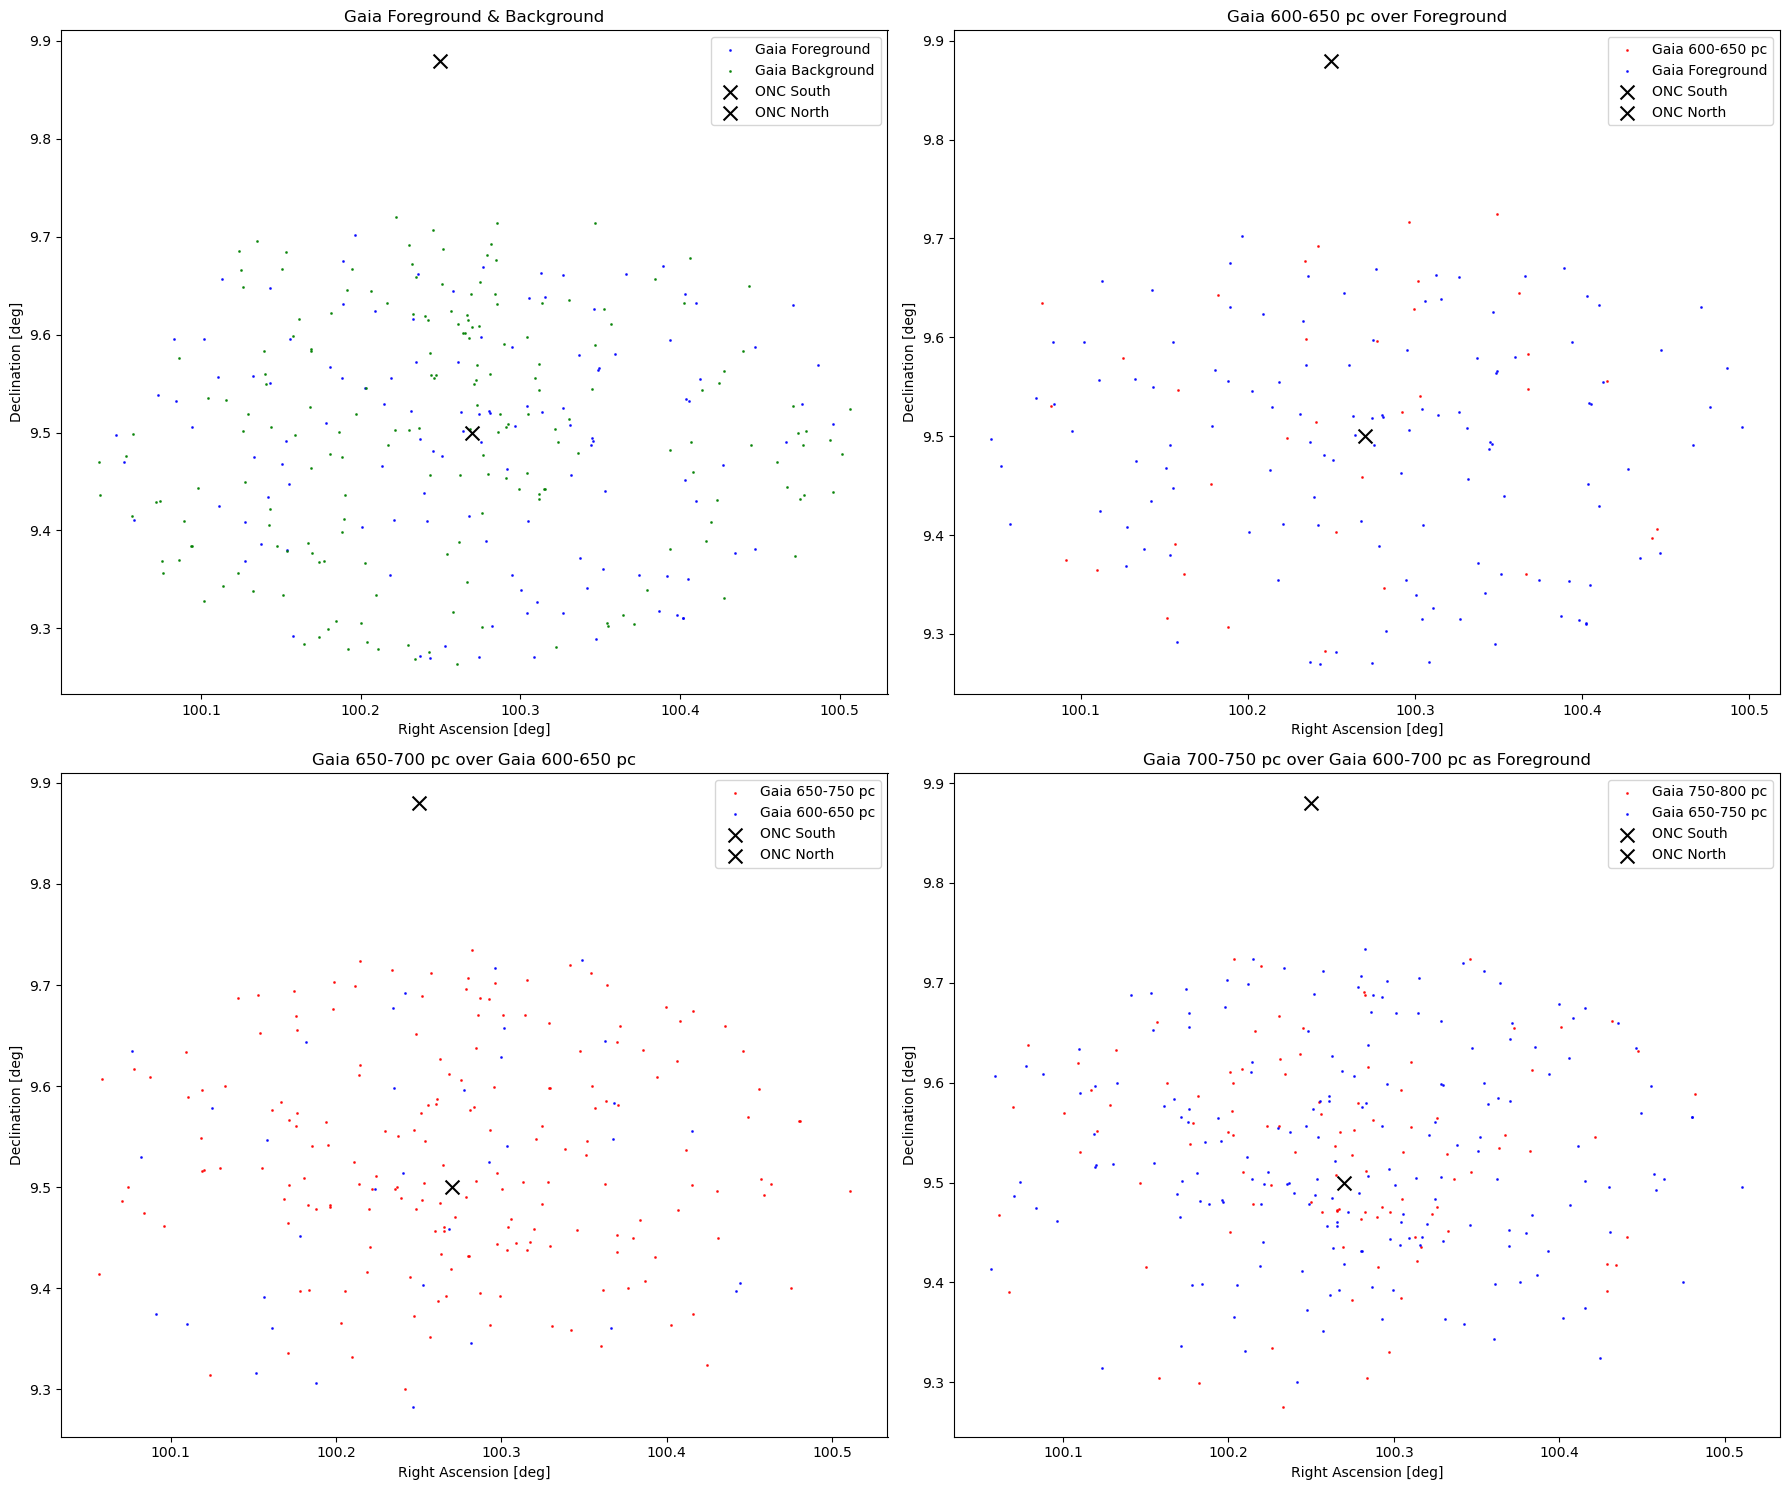

In [25]:
#South ! 
gaiaS_ra = gaia1['ra']
gaiaS_dec = gaia1['dec']
TwoMASSs_ra = TwoMASSs['ra']
TwoMASSs_dec = TwoMASSs['dec']

gaia_foreground = gaia1[(gaia1['distance'] >= 0) & (gaia1['distance'] <= 600)]
gaia_background = gaia1[(gaia1['distance'] >= 800) & (gaia1['distance'] <= 1300)]
gaia_2= gaia1[(gaia1['distance'] >= 600) & (gaia1['distance'] <= 650)]
gaia_3= gaia1[(gaia1['distance'] >= 650) & (gaia1['distance'] <= 750)]
gaia_4= gaia1[(gaia1['distance'] >= 750) & (gaia1['distance'] <= 800)]
gaia_4_1= gaia1[(gaia1['distance'] >= 650) & (gaia1['distance'] <= 750)]

# Create subplots
fig, axs = plt.subplots(2, 2, figsize=(18, 15))

# Plot 1: Gaia Foreground
axs[0, 0].scatter(gaia_foreground['ra'], gaia_foreground['dec'], s=1, color='blue', label='Gaia Foreground', alpha=0.8)
axs[0, 0].scatter(gaia_background['ra'], gaia_background['dec'], s=1, color='green', label='Gaia Background', alpha=0.8)
axs[0, 0].scatter(onc_ra, onc_dec, color='black', marker='x', s=100, label='ONC South')
axs[0, 0].scatter(onc_ra1, onc_dec1, color='black', marker='x', s=100, label='ONC North')
axs[0, 0].set_title('Gaia Foreground & Background')
axs[0, 0].set_xlabel('Right Ascension [deg]')
axs[0, 0].set_ylabel('Declination [deg]')
axs[0, 0].legend()

# Plot 2: Gaia Background
axs[0, 1].scatter(gaia_2['ra'], gaia_2['dec'], s=1, color='red', label='Gaia 600-650 pc', alpha=0.8)
axs[0, 1].scatter(gaia_foreground['ra'], gaia_foreground['dec'], s=1, color='blue', label='Gaia Foreground', alpha=0.8)
axs[0, 1].scatter(onc_ra, onc_dec, color='black', marker='x', s=100, label='ONC South')
axs[0, 1].scatter(onc_ra1, onc_dec1, color='black', marker='x', s=100, label='ONC North')
axs[0, 1].set_title('Gaia 600-650 pc over Foreground')
axs[0, 1].set_xlabel('Right Ascension [deg]')
axs[0, 1].set_ylabel('Declination [deg]')
axs[0, 1].legend()

# Plot 3: TwoMASS Data
axs[1, 0].scatter(gaia_3['ra'], gaia_3['dec'], s=1, color='red', label='Gaia 650-750 pc', alpha=0.8)
axs[1, 0].scatter(gaia_2['ra'], gaia_2['dec'], s=1, color='blue', label='Gaia 600-650 pc', alpha=0.8)
axs[1, 0].scatter(onc_ra, onc_dec, color='black', marker='x', s=100, label='ONC South')
axs[1, 0].scatter(onc_ra1, onc_dec1, color='black', marker='x', s=100, label='ONC North')
axs[1, 0].set_title('Gaia 650-700 pc over Gaia 600-650 pc')
axs[1, 0].set_xlabel('Right Ascension [deg]')
axs[1, 0].set_ylabel('Declination [deg]')
axs[1, 0].legend()

# Plot 4: Combined Data
axs[1, 1].scatter(gaia_4['ra'], gaia_4['dec'], s=1, color='red', label='Gaia 750-800 pc', alpha=0.8)
axs[1, 1].scatter(gaia_4_1['ra'], gaia_4_1['dec'], s=1, color='blue', label='Gaia 650-750 pc', alpha=0.8)
axs[1, 1].scatter(onc_ra, onc_dec, color='black', marker='x', s=100, label='ONC South')
axs[1, 1].scatter(onc_ra1, onc_dec1, color='black', marker='x', s=100, label='ONC North')
axs[1, 1].set_title('Gaia 700-750 pc over Gaia 600-700 pc as Foreground')
axs[1, 1].set_xlabel('Right Ascension [deg]')
axs[1, 1].set_ylabel('Declination [deg]')
axs[1, 1].legend()

plt.tight_layout()
plt.show()

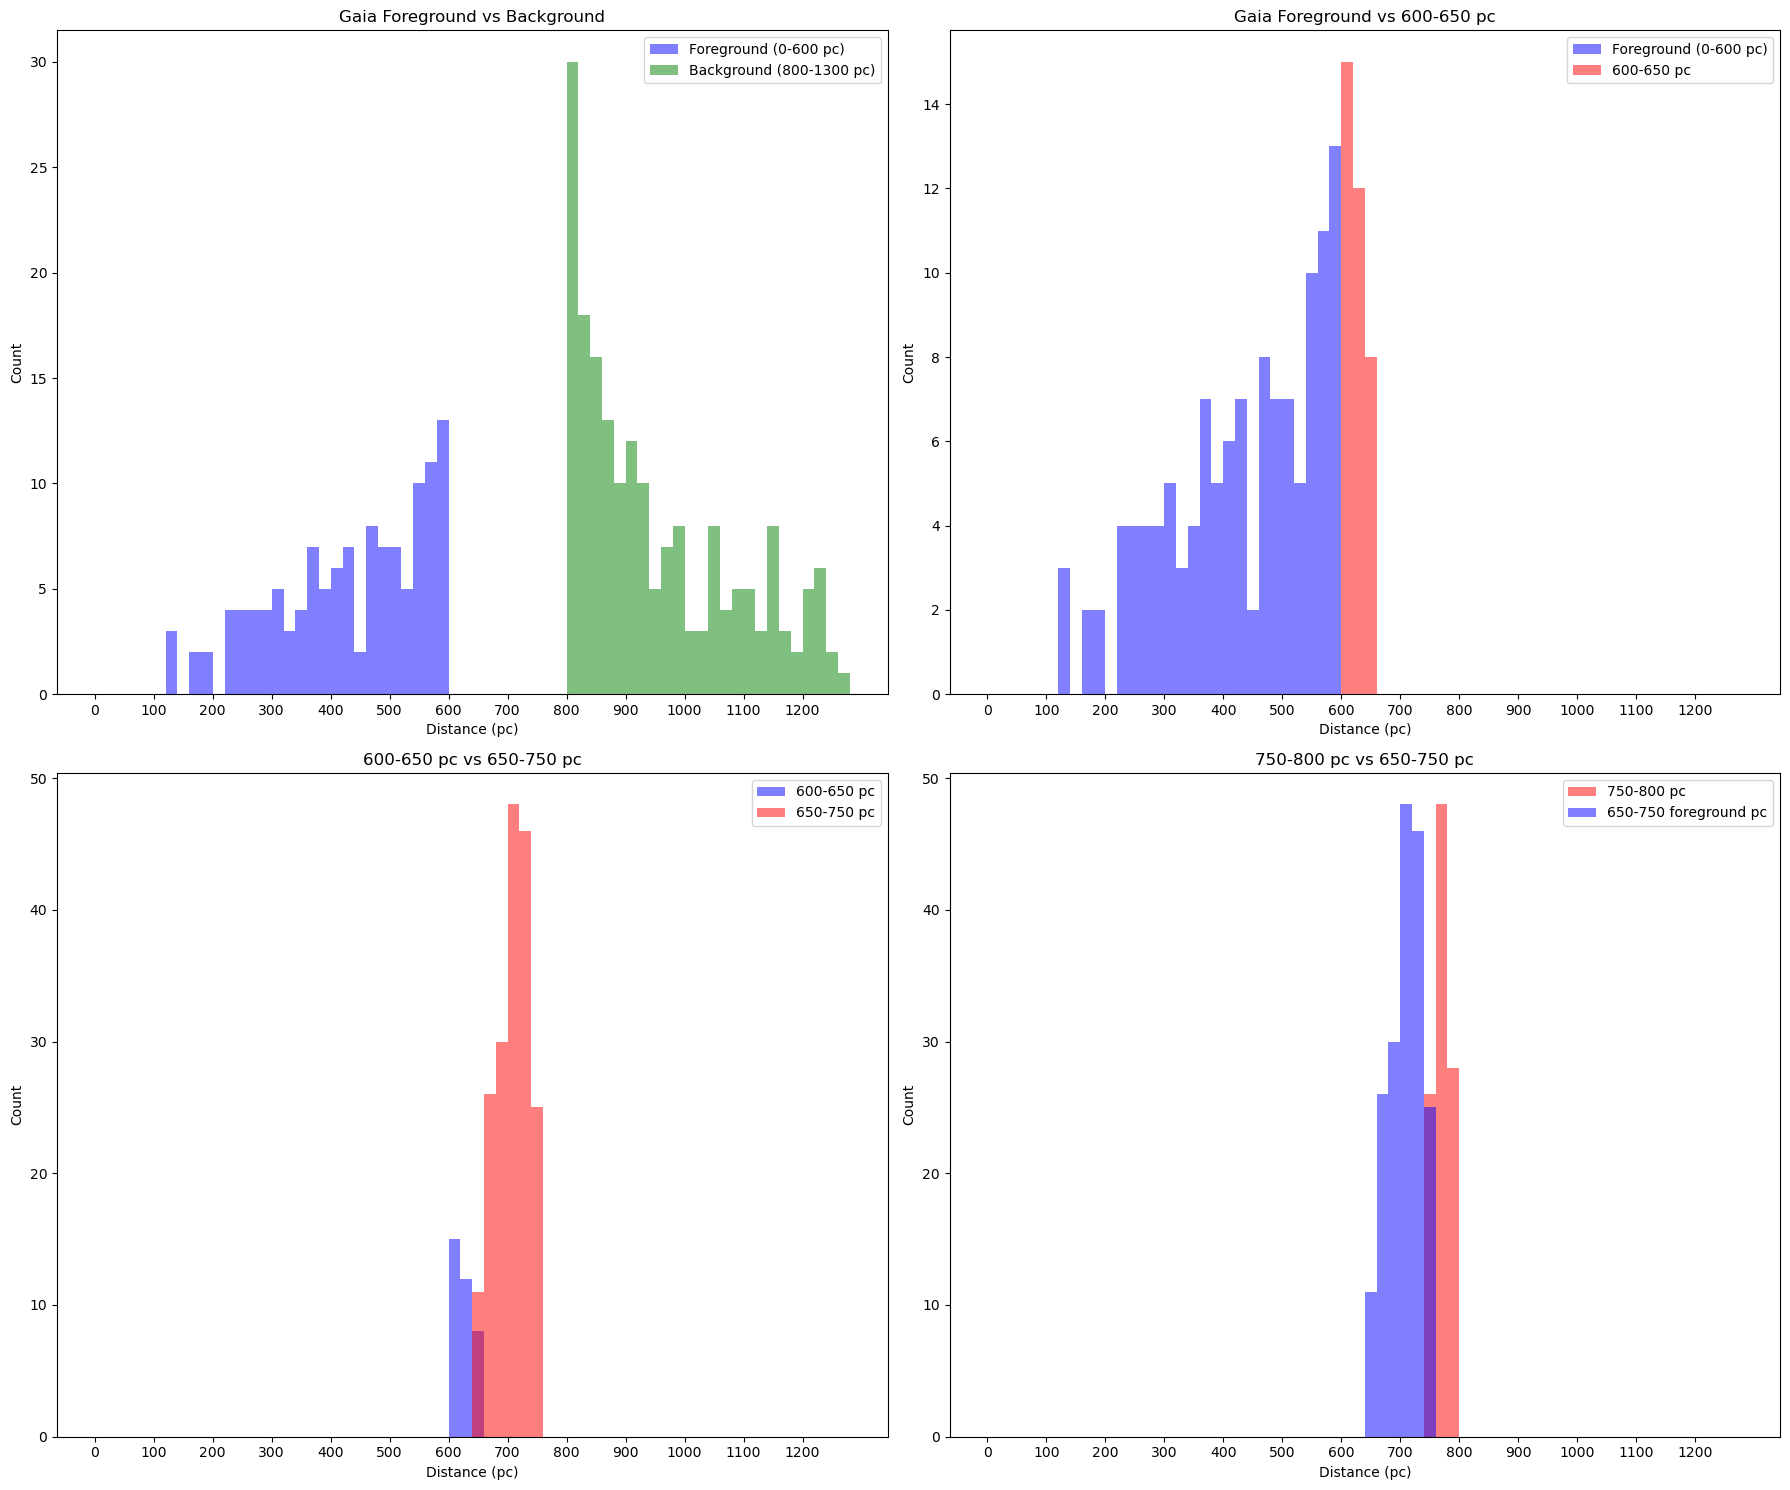

In [26]:
# Define the bins (100 pc increment)
bins = np.arange(0, 1300, 20)  # Range from 0 to 1500 pc with steps of 100 pc

# Create subplots
fig, axs = plt.subplots(2, 2, figsize=(18, 15))

# Plot 1: Gaia Foreground vs Background
axs[0, 0].hist(gaia_foreground['distance'], bins=bins, color='blue', alpha=0.5, label='Foreground (0-600 pc)')
axs[0, 0].hist(gaia_background['distance'], bins=bins, color='green', alpha=0.5, label='Background (800-1300 pc)')
axs[0, 0].set_title('Gaia Foreground vs Background')
axs[0, 0].set_xlabel('Distance (pc)')
axs[0, 0].set_ylabel('Count')
axs[0, 0].legend()

# Set x-axis ticks in increments of 100 pc
axs[0, 0].set_xticks(np.arange(0, 1300, 100))

# Plot 2: Gaia Foreground vs Gaia 600-650 pc
axs[0, 1].hist(gaia_foreground['distance'], bins=bins, color='blue', alpha=0.5, label='Foreground (0-600 pc)')
axs[0, 1].hist(gaia_2['distance'], bins=bins, color='red', alpha=0.5, label='600-650 pc')
axs[0, 1].set_title('Gaia Foreground vs 600-650 pc')
axs[0, 1].set_xlabel('Distance (pc)')
axs[0, 1].set_ylabel('Count')
axs[0, 1].legend()

# Set x-axis ticks in increments of 100 pc
axs[0, 1].set_xticks(np.arange(0, 1300, 100))

# Plot 3: Gaia 600-650 pc vs 650-750 pc
axs[1, 0].hist(gaia_2['distance'], bins=bins, color='blue', alpha=0.5, label='600-650 pc')
axs[1, 0].hist(gaia_3['distance'], bins=bins, color='red', alpha=0.5, label='650-750 pc')
axs[1, 0].set_title('600-650 pc vs 650-750 pc')
axs[1, 0].set_xlabel('Distance (pc)')
axs[1, 0].set_ylabel('Count')
axs[1, 0].legend()

# Set x-axis ticks in increments of 100 pc
axs[1, 0].set_xticks(np.arange(0, 1300, 100))

# Plot 4: Gaia 750-800 pc vs 650-750 pc
axs[1, 1].hist(gaia_4['distance'], bins=bins, color='red', alpha=0.5, label='750-800 pc')
axs[1, 1].hist(gaia_4_1['distance'], bins=bins, color='blue', alpha=0.5, label='650-750 foreground pc')
axs[1, 1].set_title('750-800 pc vs 650-750 pc')
axs[1, 1].set_xlabel('Distance (pc)')
axs[1, 1].set_ylabel('Count')
axs[1, 1].legend()

# Set x-axis ticks in increments of 100 pc
axs[1, 1].set_xticks(np.arange(0, 1300, 100))

# Adjust layout and show the plots
plt.tight_layout()
plt.show()

#Looks like around 700 pc but there is another single peak at around 760/770 pc

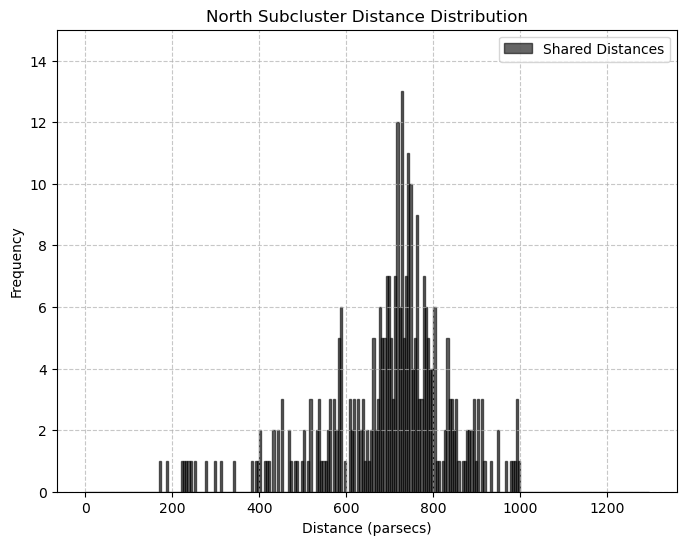

In [27]:
# SHARED GAIA+2MASS FROM 0 TO 1000 NORTH
plt.figure(figsize=(8,6))

# Define bin size and range
bin_size = 5
bins = np.arange(0, 1300, bin_size)

plt.hist(distances_greenss, bins=bins, alpha=0.6, color='black', edgecolor='black', label='Shared Distances')


plt.title('North Subcluster Distance Distribution')
plt.xlabel('Distance (parsecs)')
plt.ylabel('Frequency')
plt.grid(True, linestyle='--', alpha=0.7)
plt.ylim(0, 15)

plt.legend()  # Add a legend to distinguish the histograms
plt.show()



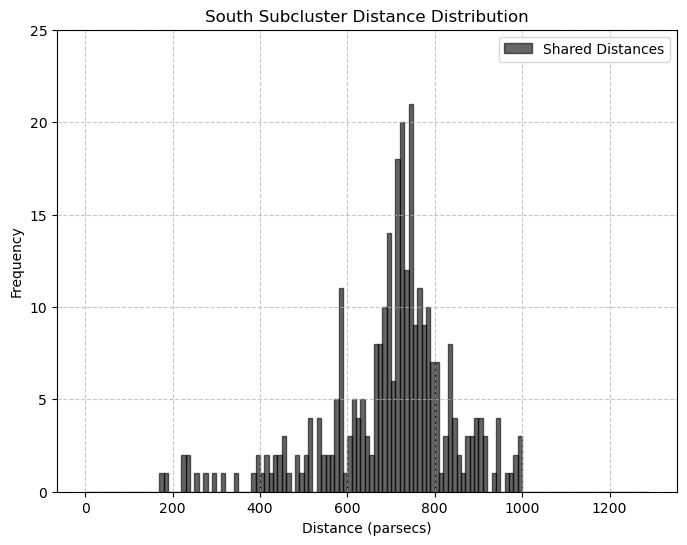

In [28]:
# SHARED GAIA+2MASS FROM 0 TO 1000 SOUTH

plt.figure(figsize=(8,6))

# Define bin size and range
bin_size = 10
bins = np.arange(0, 1300, bin_size)  # Bins from 150 to 1000 with a step of 30

plt.hist(distances_greensSS, bins=bins, alpha=0.6, color='black', edgecolor='black', label='Shared Distances')


plt.title('South Subcluster Distance Distribution')
plt.xlabel('Distance (parsecs)')
plt.ylabel('Frequency')
plt.grid(True, linestyle='--', alpha=0.7)
plt.ylim(0, 25)

plt.legend()  # Add a legend to distinguish the histograms
plt.show()




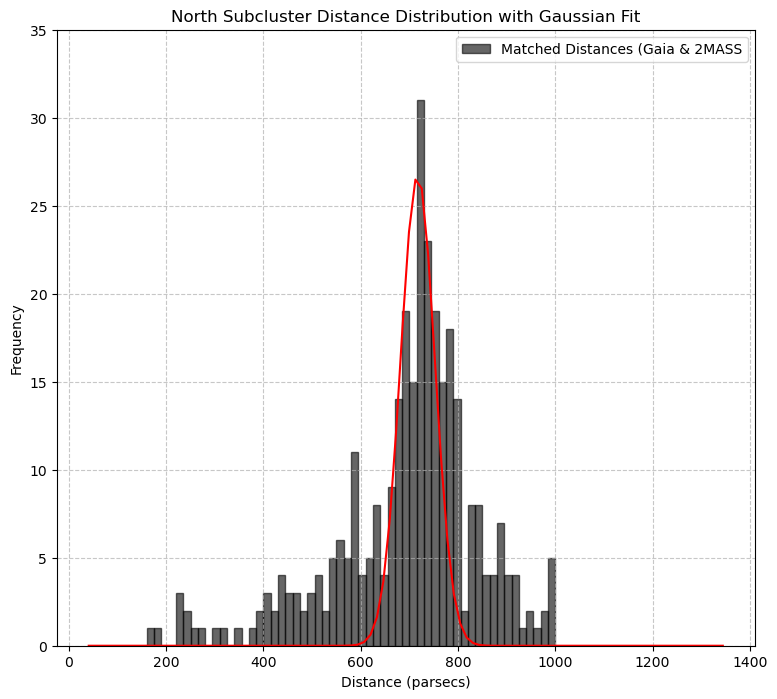

In [29]:

plt.figure(figsize=(9, 8))


bin_size = 15
bins = np.arange(100, 1300, bin_size)  # Bins from 100 to 1300 with a step of 10

distances_greenss = np.array(distances_greenss)  # Ensure it's a NumPy array



# Calculate the 25th and 75th percentiles (IQR range) for distance
lower_percentile = np.percentile(distances_greenss, 25)
upper_percentile = np.percentile(distances_greenss, 75)

# Select data between 25th and 75th percentiles for Gaussian fit
filtered_data_gaussian = distances_greenss[(distances_greenss >= lower_percentile) & (distances_greenss <= upper_percentile)]

# Plot the histogram for all data (100-1300 parsecs)
plt.hist(distances_greenss, bins=bins, alpha=0.6, color='black', edgecolor='black', label='Matched Distances (Gaia & 2MASS')

# Calculate the mean and standard deviation of the filtered data for Gaussian fit
mean_gaussian = np.mean(filtered_data_gaussian)
std_gaussian = np.std(filtered_data_gaussian)

# Generate x values for plotting the Gaussian curve
xmin, xmax = plt.xlim()  # Get the current x-axis limits
x = np.linspace(xmin, xmax, 100)

# Calculate the Gaussian PDF (probability density function) for the filtered data (IQR)
p = norm.pdf(x, mean_gaussian, std_gaussian)

# Scale the Gaussian curve to match the histogram's scale
p_scaled = p * len(filtered_data_gaussian) * bin_size

# Plot the Gaussian curve on top of the histogram
plt.plot(x, p_scaled, 'r-')

# Title and labels
plt.title('North Subcluster Distance Distribution with Gaussian Fit')
plt.xlabel('Distance (parsecs)')
plt.ylabel('Frequency')

# Grid, legend, and y-axis limits
plt.grid(True, linestyle='--', alpha=0.7)
plt.ylim(0, 35)
plt.legend()

# Show the plot
plt.show()


Mean: 743.2459372042164, Std Dev: 12.27998334974778


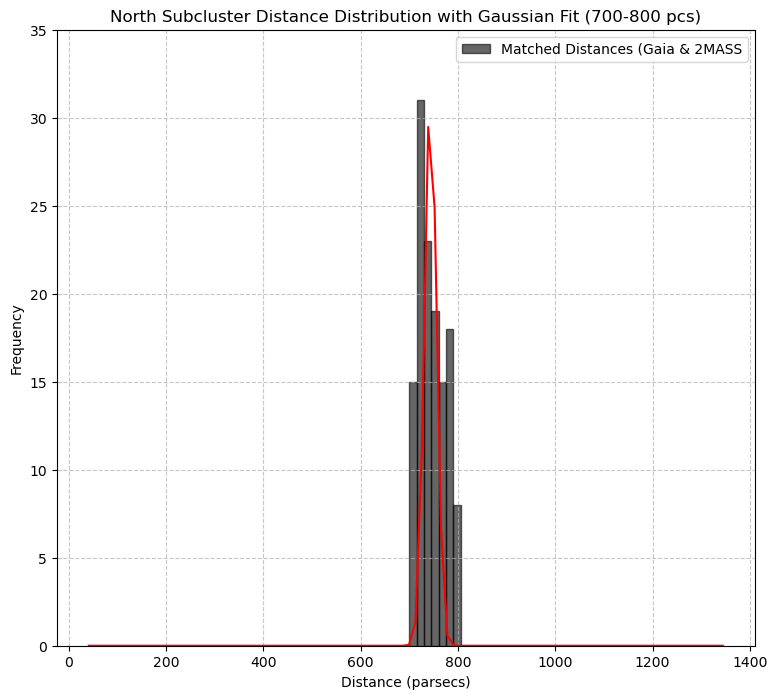

In [30]:

plt.figure(figsize=(9, 8))


bin_size = 15
bins = np.arange(100, 1300, bin_size)  # Bins from 100 to 1300 with a step of 10

distances_greens = np.array(distances_greens)  # Ensure it's a NumPy array



# Calculate the 25th and 75th percentiles (IQR range) for distance
lower_percentile = np.percentile(distances_greens, 25)
upper_percentile = np.percentile(distances_greens, 75)

# Select data between 25th and 75th percentiles for Gaussian fit
filtered_data_gaussian2 = distances_greens[(distances_greens >= lower_percentile) & (distances_greens <= upper_percentile)]

# Plot the histogram for all data (100-1300 parsecs)
plt.hist(distances_greens, bins=bins, alpha=0.6, color='black', edgecolor='black', label='Matched Distances (Gaia & 2MASS')

mean_gaussian = np.mean(filtered_data_gaussian2)
std_gaussian = np.std(filtered_data_gaussian2)
print(f"Mean: {mean_gaussian}, Std Dev: {std_gaussian}")

# Generate x values for plotting the Gaussian curve
xmin, xmax = plt.xlim()  # Get the current x-axis limits
x = np.linspace(xmin, xmax, 100)

# Calculate the Gaussian PDF (probability density function) for the filtered data (IQR)
p = norm.pdf(x, mean_gaussian, std_gaussian)

# Scale the Gaussian curve to match the histogram's scale
p_scaled = p * len(filtered_data_gaussian2) * bin_size

# Plot the Gaussian curve on top of the histogram
plt.plot(x, p_scaled, 'r-')

# Title and labels
plt.title('North Subcluster Distance Distribution with Gaussian Fit (700-800 pcs)')
plt.xlabel('Distance (parsecs)')
plt.ylabel('Frequency')

# Grid, legend, and y-axis limits
plt.grid(True, linestyle='--', alpha=0.7)
plt.ylim(0, 35)
plt.legend()

# Show the plot
plt.show()


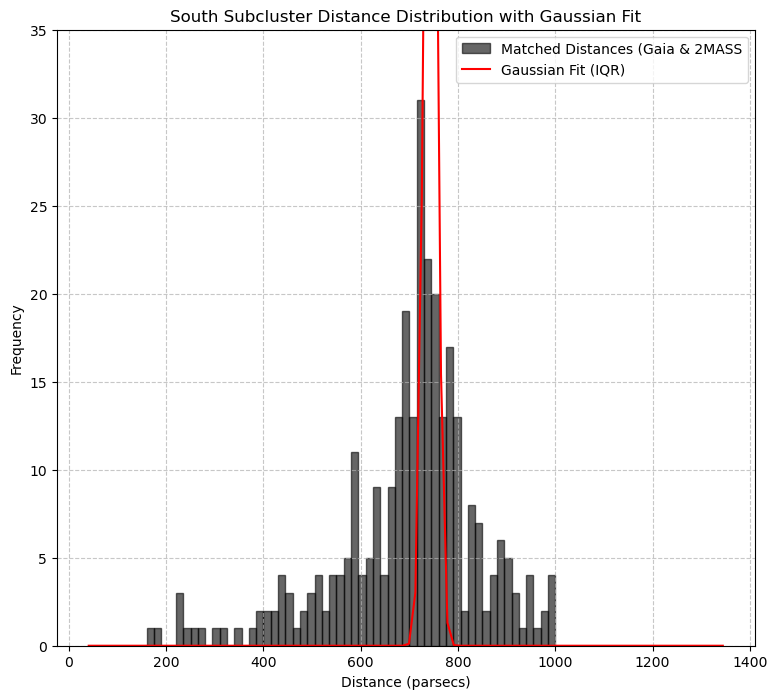

In [31]:
plt.figure(figsize=(9, 8))

# Define bin size and range for histogram
bin_size = 15
bins = np.arange(100, 1300, bin_size)  # Bins from 100 to 1300 with a step of 15

distances_greensSS = np.array(distances_greensSS)  # Ensure it's a NumPy array



# Calculate the 25th and 75th percentiles (IQR range) for distance
lower_percentile = np.percentile(distances_greensSS, 25)
upper_percentile = np.percentile(distances_greensSS, 75)

# Select data between 25th and 75th percentiles for Gaussian fit
filtered_data_gaussian1 = distances_greensSS[(distances_greensSS >= lower_percentile) & (distances_greensSS <= upper_percentile)]

# Plot the histogram for all data (100-1300 parsecs)
plt.hist(distances_greensSS, bins=bins, alpha=0.6, color='black', edgecolor='black', label='Matched Distances (Gaia & 2MASS')


# Generate x values for plotting the Gaussian curve
xmin, xmax = plt.xlim()  # Get the current x-axis limits
x = np.linspace(xmin, xmax, 100)

# Calculate the Gaussian PDF (probability density function) for the filtered data (IQR)
p = norm.pdf(x, mean_gaussian, std_gaussian)

# Scale the Gaussian curve to match the histogram's scale
p_scaled = p * len(filtered_data_gaussian1) * bin_size

# Plot the Gaussian curve on top of the histogram
plt.plot(x, p_scaled, 'r-', label='Gaussian Fit (IQR)')

# Title and labels
plt.title('South Subcluster Distance Distribution with Gaussian Fit')
plt.xlabel('Distance (parsecs)')
plt.ylabel('Frequency')

# Grid, legend, and y-axis limits
plt.grid(True, linestyle='--', alpha=0.7)
plt.ylim(0, 35)
plt.legend()

# Show the plot
plt.show()

Mean: 742.6481078654639, Std Dev: 11.399582799768723


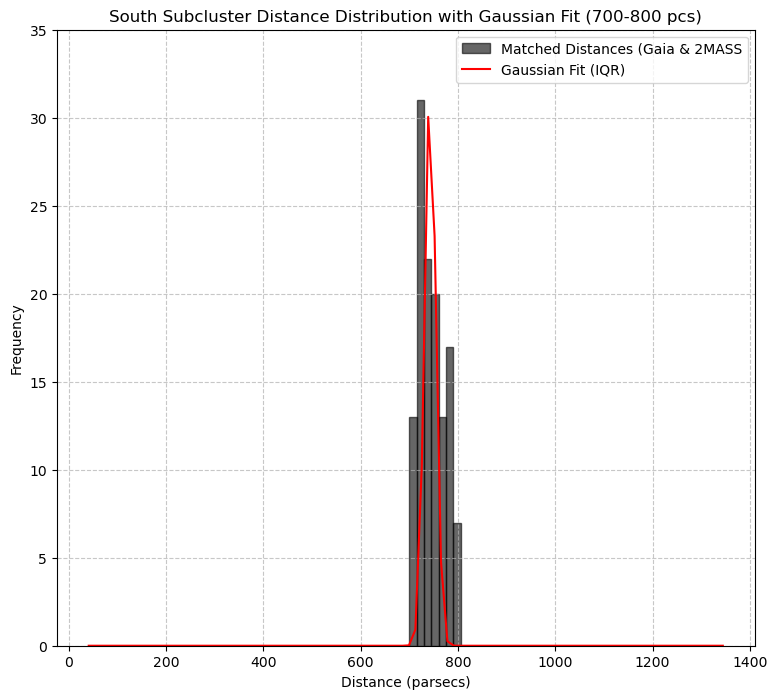

In [32]:
plt.figure(figsize=(9, 8))

# Define bin size and range for histogram
bin_size = 15
bins = np.arange(100, 1300, bin_size)  # Bins from 100 to 1300 with a step of 15

distances_greensS = np.array(distances_greensS)  # Ensure it's a NumPy array



# Calculate the 25th and 75th percentiles (IQR range) for distance
lower_percentile = np.percentile(distances_greensS, 25)
upper_percentile = np.percentile(distances_greensS, 75)

# Select data between 25th and 75th percentiles for Gaussian fit
filtered_data_gaussian3 = distances_greensS[(distances_greensS >= lower_percentile) & (distances_greensS <= upper_percentile)]

# Plot the histogram for all data (100-1300 parsecs)
plt.hist(distances_greensS, bins=bins, alpha=0.6, color='black', edgecolor='black', label='Matched Distances (Gaia & 2MASS')

# Check Gaussian statistics
mean_gaussian = np.mean(filtered_data_gaussian3)
std_gaussian = np.std(filtered_data_gaussian3)
print(f"Mean: {mean_gaussian}, Std Dev: {std_gaussian}")

# Generate x values for plotting the Gaussian curve
xmin, xmax = plt.xlim()  # Get the current x-axis limits
x = np.linspace(xmin, xmax, 100)

# Calculate the Gaussian PDF (probability density function) for the filtered data (IQR)
p = norm.pdf(x, mean_gaussian, std_gaussian)

# Scale the Gaussian curve to match the histogram's scale
p_scaled = p * len(filtered_data_gaussian3) * bin_size

# Plot the Gaussian curve on top of the histogram
plt.plot(x, p_scaled, 'r-', label='Gaussian Fit (IQR)')

# Title and labels
plt.title('South Subcluster Distance Distribution with Gaussian Fit (700-800 pcs)')
plt.xlabel('Distance (parsecs)')
plt.ylabel('Frequency')

# Grid, legend, and y-axis limits
plt.grid(True, linestyle='--', alpha=0.7)
plt.ylim(0, 35)
plt.legend()

# Show the plot
plt.show()

In [33]:
#NEW NORTH from the conclusion that center may be between 700-800 definitely

from astropy.coordinates import SkyCoord
from astropy import units as u
from astroquery.gaia import Gaia

def fetch_and_filter_gaia_data(ra, dec, radius=0.24):
    # Define coordinates
    coord = SkyCoord(ra=ra, dec=dec, unit=(u.degree, u.degree), frame='icrs')
    
    # Perform cone search
    job = Gaia.cone_search_async(coord, radius=u.Quantity(radius, u.deg))
    results = job.get_results()
    
    # Convert to pandas DataFrame
    gaia_df = results.to_pandas()
    
    # Drop rows with NaN values in 'parallax' column
    gaia_df = gaia_df.dropna(subset=['parallax'])
    
    # Create a new DataFrame for calculations
    filtered_df = gaia_df.copy()
    
    # Calculate distance from parallax
    filtered_df['distance'] = 1 / ((10**-3) * abs(filtered_df['parallax']))
    
    # Filter distances
    filtered_df = filtered_df[(filtered_df['distance'] >= 700) & (filtered_df['distance'] <= 840)]
    filtered_df = filtered_df[filtered_df['parallax_error'] <= 0.3] 
    
    return filtered_df.reset_index(drop=True)

# Usage
onc_ra = 100.25  # degrees
onc_dec = 9.88

gaiaN = fetch_and_filter_gaia_data(onc_ra, onc_dec)
print(gaiaN)

INFO: Query finished. [astroquery.utils.tap.core]
             solution_id                   DESIGNATION            SOURCE_ID  \
0    1635721458409799680  Gaia DR2 3326740693770240640  3326740693770240640   
1    1635721458409799680  Gaia DR2 3326740762491769088  3326740762491769088   
2    1635721458409799680  Gaia DR2 3326740758201316608  3326740758201316608   
3    1635721458409799680  Gaia DR2 3326740693772848896  3326740693772848896   
4    1635721458409799680  Gaia DR2 3326740689481840896  3326740689481840896   
..                   ...                           ...                  ...   
268  1635721458409799680  Gaia DR2 3326709971871404672  3326709971871404672   
269  1635721458409799680  Gaia DR2 3326936097605019136  3326936097605019136   
270  1635721458409799680  Gaia DR2 3326910568319185408  3326910568319185408   
271  1635721458409799680  Gaia DR2 3326934276538636288  3326934276538636288   
272  1635721458409799680  Gaia DR2 3326709215956587264  3326709215956587264   

 

In [34]:
SIMBAD_ra = 100.25
SIMBAD_dec = 9.88
surv_ra = SIMBAD_ra + 0.0013
surv_dec = SIMBAD_dec + 0.0013

# Prepare the query
query = f"""
    SELECT ra, dec, j_m, j_msigcom, h_m, h_msigcom, k_m, k_msigcom, ph_qual, cc_flg
    FROM fp_psc
    WHERE CONTAINS(POINT('ICRS', ra, dec), CIRCLE('ICRS', {surv_ra}, {surv_dec}, 0.22)) = 1
"""

# Access the TAP service and run the query
service = pyvo.dal.TAPService('https://irsa.ipac.caltech.edu/TAP')
result = service.run_async(query)

# Handle the result
try:
    TwoMASSN = result.to_table()
    print(TwoMASSN)
    
    # Making necessary 4 lists
    ra_G = gaiaN['ra'].tolist()  # Replace 'df' with your Gaia DataFrame if needed
    dec_G = gaiaN['dec'].tolist()  # Replace 'df' with your Gaia DataFrame if needed
    ra_TM = TwoMASSN['ra'].tolist()
    dec_TM = TwoMASSN['dec'].tolist()
    
except Exception as e:
    print(f"An error occurred: {e}")

    ra        dec     j_m   j_msigcom  h_m   ...  k_m   k_msigcom ph_qual cc_flg
   deg        deg     mag      mag     mag   ...  mag      mag                  
---------- --------- ------ --------- ------ ... ------ --------- ------- ------
100.184806 10.046662 14.361     0.037 14.011 ... 13.833     0.051     AAA    000
100.168597 10.047357 16.047     0.081 15.516 ... 15.003     0.126     AAB    000
100.175188 10.040696 16.065     0.112 15.388 ... 15.176     0.171     BAC    000
100.170251 10.050909 16.144        -- 15.809 ... 16.249        --     UBU    000
100.177642 10.041435 16.263     0.149 15.805 ... 15.324     0.203     BBC    000
100.179467 10.072316 16.928     0.204 15.943 ... 15.009        --     DBU    000
100.181967 10.067764 16.232     0.139 15.538 ... 15.075     0.170     BBC    000
100.146324 10.072726 12.229     0.026 11.537 ... 11.368     0.021     AAA    000
100.162684 10.060035 16.345     0.112 15.586 ... 15.077     0.173     BBC    000
       ...       ...    ... 

In [35]:

matched_rows = []

# Create an empty DataFrame for unmatched sources
did_not_match = pd.DataFrame(columns=TwoMASSN.colnames)

# Define the tolerance for RA and DEC differences (in degrees)
tolerance = 0.001  # Adjust this as needed

# Convert TwoMASS to a pandas DataFrame for easier manipulation
TwoMASSN_df = Table.to_pandas(TwoMASSN)

# Function to convert parallax from mas to distance in parsecs
def parallax_to_distance(parallax_mas):
    if parallax_mas > 0:
        return 1000 / parallax_mas  # Distance in parsecs
    else:
        return np.nan  # Return NaN for non-positive parallax

# Iterate over each row in TwoMASS
for index, row in TwoMASSN_df.iterrows():
    ra_tm = row['ra']
    dec_tm = row['dec']
    matched = False  # Flag to check if a match is found

    # Iterate over each row in gaia_v2
    for _, gaia_row in gaia1.iterrows():
        ra_gaia = gaia_row['ra']
        dec_gaia = gaia_row['dec']
        parallax_gaia = gaia_row['parallax']  # Extract parallax from Gaia

        # Calculate the angular distance using a strict tolerance
        distance = np.sqrt((ra_tm - ra_gaia) ** 2 + (dec_tm - dec_gaia) ** 2)

        # Check if the distance is within the defined tolerance
        if distance <= tolerance:
            # If a match is found, prepare the new row
            new_row = row.to_dict()  # Convert the row to a dictionary
            new_row['parallax'] = parallax_gaia  # Add Gaia's parallax
            
            # Convert parallax to distance
            new_row['distance'] = parallax_to_distance(parallax_gaia)  # Distance in parsecs
            
            # Append to matched_rows list
            matched_rows.append(new_row)
            matched = True  # A match was found
            break  # Exit the inner loop as we found a match

    if not matched:
        # If no match was found, add the current row to did_not_match
        did_not_match = pd.concat([did_not_match, pd.DataFrame([row])], ignore_index=True)


filtered_TwoMASSN = pd.DataFrame(matched_rows)
filtered_TwoMASSN = filtered_TwoMASSN[(filtered_TwoMASSN['distance'] >= 700) & (filtered_TwoMASSN['distance'] <= 840)]

# Check for duplicates in the matched DataFrame based on RA and DEC
duplicates = filtered_TwoMASSN[filtered_TwoMASSN.duplicated(subset=['ra', 'dec'], keep=False)]

# Print duplicates if they exist
if not duplicates.empty:
    print("Duplicates found:")
    print(duplicates)

# Print the filtered DataFrame with matches
print("Matched DataFrame:")
print(filtered_TwoMASSN)

# Print the DataFrame with unmatched sources
print("Did Not Match DataFrame:")
print(did_not_match)

NameError: name 'Table' is not defined

In [ ]:

plt.figure(figsize=(9, 8))


bin_size = 20
bins = np.arange(500, 1000, bin_size)  # Bins from 100 to 1300 with a step of 10

# All data from 100 to 1300 parsecs
all_data = filtered_TwoMASSN['distance']

# Calculate the 25th and 75th percentiles (IQR range) for distance
lower_percentile = np.percentile(all_data, 25)
upper_percentile = np.percentile(all_data, 75)

# Select data between 25th and 75th percentiles for Gaussian fit
filtered_data_gaussian = all_data[(all_data >= lower_percentile) & (all_data <= upper_percentile)]

# Plot the histogram for all data (100-1300 parsecs)
plt.hist(all_data, bins=bins, alpha=0.6, color='black', edgecolor='black', label='Matched Distances (Gaia & 2MASS')


mean_gaussian = 750
std_gaussian = np.std(filtered_data_gaussian)  # Keep the standard deviation from your data


# Generate x values for plotting the Gaussian curve
xmin, xmax = plt.xlim()  # Get the current x-axis limits
x = np.linspace(xmin, xmax, 100)

# Calculate the Gaussian PDF (probability density function) for the filtered data (IQR)
p = norm.pdf(x, mean_gaussian, std_gaussian)

# Scale the Gaussian curve to match the histogram's scale
p_scaled = p * len(filtered_data_gaussian) * bin_size

# Plot the Gaussian curve on top of the histogram
plt.plot(x, p_scaled, 'r-')

# Title and labels
plt.title('North Subcluster (700-800 pcs) Distance Distribution with Gaussian Fit')
plt.xlabel('Distance (parsecs)')
plt.ylabel('Frequency')

# Grid, legend, and y-axis limits
plt.grid(True, linestyle='--', alpha=0.7)
plt.ylim(0, 8)
plt.legend()

# Show the plot
plt.show()

In [ ]:
# Filter the data based on distance and error thresholds for J, H, K
filtered_TwoMASS = filtered_TwoMASS[
    (filtered_TwoMASS['distance_pc'] >= 720) & 
    (filtered_TwoMASS['distance_pc'] <= 780) &
    (filtered_TwoMASS['j_msigcom'] < 0.1) & 
    (filtered_TwoMASS['h_msigcom'] < 0.1) & 
    (filtered_TwoMASS['k_msigcom'] < 0.1)
]

filtered_TwoMASSs = filtered_TwoMASSs[
    (filtered_TwoMASSs['distance_pc'] >= 720) & 
    (filtered_TwoMASSs['distance_pc'] <= 780) &
    (filtered_TwoMASSs['j_msigcom'] < 0.1) & 
    (filtered_TwoMASSs['h_msigcom'] < 0.1) & 
    (filtered_TwoMASSs['k_msigcom'] < 0.1)
]

# Now you can extract the relevant columns and compute NHK, NJH, SHK, SJH for the filtered data
df = filtered_TwoMASS[['j_m', 'k_m', 'h_m']]
df1 = filtered_TwoMASSs[['j_m', 'k_m', 'h_m']]

# Calculate NHK and NJH for the filtered data
NHK = df['h_m'] - df['k_m']
NJH = df['j_m'] - df['h_m']

SHK = df1['h_m'] - df1['k_m']
SJH = df1['j_m'] - df1['h_m']

# Compute filtered rows for further analysis
filtered_NHK = filtered_TwoMASS['h_m'] - filtered_TwoMASS['k_m']
filtered_NJH = filtered_TwoMASS['j_m'] - filtered_TwoMASS['h_m']

filtered_SHK = filtered_TwoMASSs['h_m'] - filtered_TwoMASSs['k_m']
filtered_SJH = filtered_TwoMASSs['j_m'] - filtered_TwoMASSs['h_m']




In [ ]:
mainsequence_j_k_koornneef83 = np.array([-0.21, -0.19, -0.18, -0.17, -0.15, -0.14, -0.13, -0.11, -0.1, -0.08, -0.07, -0.05, -0.04, -0.02, 0.01, 0.02, 0.04, 0.05, 0.07, 0.09, 0.1, 0.12, 0.14, 0.17, 0.2, 0.24, 0.26, 0.29, 0.31, 0.37, 0.41, 0.47, 0.54, 0.62, 0.67, 0.72, 0.77, 0.83, 0.86, 0.89, 0.92, 0.9, 0.9, 0.88, 0.89, 0.9, 0.92, 0.95, 0.98, 1.01, 1.05, 1.09, 1.11, 1.14])
mainsequence_h_k_koornneef83 = np.array([-0.05, -0.05, -0.05, -0.05, -0.04, -0.04, -0.04, -0.03, -0.03, -0.02, -0.02, -0.02, -0.01, -0.01, 0, 0, 0.01, 0.01, 0.02, 0.02, 0.02, 0.02, 0.03, 0.04, 0.04, 0.05, 0.06, 0.06, 0.07, 0.08, 0.09, 0.1, 0.11, 0.13, 0.14, 0.15, 0.16, 0.18, 0.19, 0.21, 0.26, 0.28, 0.29, 0.3, 0.31, 0.33, 0.34, 0.36, 0.37, 0.38, 0.4, 0.41, 0.42, 0.43])
mainsequence_j_h_koornneef83 = [mainsequence_j_k_koornneef83[i] - mainsequence_h_k_koornneef83[i] for i in range(54)]
mainsequence_k_koornneef83 = [mainsequence_j_k_koornneef83[i] - mainsequence_h_k_koornneef83[i] for i in range(54)]
giant_j_k_koornneef83 = np.array([0.56, 0.59, 0.64, 0.68, 0.72, 0.8, 0.88, 0.96, 0.97, 1.01, 1.04, 1.1, 1.16, 1.24, 1.3])
giant_h_k_koornneef83 = np.array([0.11, 0.12, 0.13, 0.14, 0.14, 0.16, 0.18, 0.2, 0.21, 0.21, 0.23, 0.25, 0.27, 0.31, 0.35])
giant_j_h_koornneef83 = [giant_j_k_koornneef83[i] - giant_h_k_koornneef83[i] for i in range(len(giant_j_k_koornneef83))]

# Transformations from Carpenter 2001
mainsequence_j_k_2mass = [((0.970 * i) - 0.017) for i in mainsequence_j_k_koornneef83]
mainsequence_h_k_2mass = [((0.792 * i) + 0.027) for i in mainsequence_h_k_koornneef83]
mainsequence_j_h_2mass = [((1.024 * i) - 0.045) for i in mainsequence_j_h_koornneef83]
mainsequence_k_2mass = [(mainsequence_k_koornneef83[i] + (0.039 * mainsequence_j_k_2mass[i]) - 0.047) for i in range(0, len(mainsequence_k_koornneef83))]
giant_j_k_2mass = [((0.970 * i) - 0.017) for i in giant_j_k_koornneef83]
giant_h_k_2mass = [((0.792 * i) + 0.027) for i in giant_h_k_koornneef83]
giant_j_h_2mass = [((1.024 * i) - 0.045) for i in giant_j_h_koornneef83]

# Fit a 10th-degree polynomial to the data for the main sequence stars
x = mainsequence_h_k_2mass
y = mainsequence_j_h_2mass
z = np.polyfit(x, y, 10)
f = np.poly1d(z)

# Create interpolated values using the polynomial fit
mainsequence_h_k = np.linspace(x[0], x[-1], 50)
mainsequence_j_h = f(mainsequence_h_k)

# Convert magnitudes to flux
jzp = 1594.0 * 10**6
hzp = 1024.0 * 10**6
kzp = 666.7 * 10**6

# Extinction coefficients
A_V = 1.0  # arbitrary value, the ratio is what's important
A_J = 0.282 * A_V
A_H = 0.175 * A_V
A_K = 0.112 * A_V

# Reddening vector slopes
E_J_H = A_J - A_H
E_H_K = A_H - A_K
reddening_slope = E_J_H / E_H_K

# Define reddening vectors
vector_length = 0.8  # arbitrary length for the vector

start_giant = None
for h_k, j_h in zip(giant_h_k_2mass, giant_j_h_2mass):
    if 0.2 <= h_k <= 0.3 and 0.85 <= j_h <= 0.9:
        start_giant = (h_k, j_h)
        break

# Find the starting point for the main sequence within the specified range
start_mainsequence = None
for h_k, j_h in zip(mainsequence_h_k, mainsequence_j_h):
    if 0.0 <= h_k <= 0.1 and 0.1 <= j_h <= 0.2:
        start_mainsequence = (h_k, j_h)
        break

if start_giant:
    end_giant = (start_giant[0] + vector_length, start_giant[1] + vector_length * reddening_slope)
else:
    end_giant = None

if start_mainsequence:
    end_mainsequence = (start_mainsequence[0] + vector_length, start_mainsequence[1] + vector_length * reddening_slope)
else:
    end_mainsequence = None

plt.figure(figsize=(9, 8.5))
plt.plot(giant_h_k_2mass, giant_j_h_2mass, color='black', linestyle='--', label="Giant")
plt.plot(mainsequence_h_k, mainsequence_j_h, color='black', label="Main Sequence", linestyle='-')  # Main sequence data as a line plot
plt.scatter(filtered_NHK, filtered_NJH, color='black', label="North Cluster", marker='o', s=5)  # Assuming JHK_df is defined elsewhere

if start_giant and end_giant:
    plt.arrow(start_giant[0], start_giant[1], end_giant[0] - start_giant[0], end_giant[1] - start_giant[1],
              color='black', linestyle=':', label="Reddening Vector (Giant)")

if start_mainsequence and end_mainsequence:
    plt.arrow(start_mainsequence[0], start_mainsequence[1], end_mainsequence[0] - start_mainsequence[0], end_mainsequence[1] - start_mainsequence[1],
              color='black', linestyle=':', label="Reddening Vector (Main Sequence)")

plt.xlabel('H-K')
plt.ylabel('J-H')
plt.ylim(-.03, 2.5)
plt.xlim(-.03, 1.8)
plt.legend()
plt.title('Color-Color Diagram')
plt.savefig('Color-Color Diagram (North)', dpi=100, bbox_inches='tight')

plt.show()

In [ ]:
right_most_sources = filtered_TwoMASS[
    (filtered_NHK > 0.4) &    # Filter for H-K in the right-most region (adjust value as needed)
    (filtered_NJH > 0.4)      # Filter for J-H in the right-most region (adjust value as needed)
]

# Display the filtered data points
print(f"Number of right-most reddening vector sources: {len(right_most_sources)}")


In [ ]:
mainsequence_j_k_koornneef83 = np.array([-0.21, -0.19, -0.18, -0.17, -0.15, -0.14, -0.13, -0.11, -0.1, -0.08, -0.07, -0.05, -0.04, -0.02, 0.01, 0.02, 0.04, 0.05, 0.07, 0.09, 0.1, 0.12, 0.14, 0.17, 0.2, 0.24, 0.26, 0.29, 0.31, 0.37, 0.41, 0.47, 0.54, 0.62, 0.67, 0.72, 0.77, 0.83, 0.86, 0.89, 0.92, 0.9, 0.9, 0.88, 0.89, 0.9, 0.92, 0.95, 0.98, 1.01, 1.05, 1.09, 1.11, 1.14])
mainsequence_h_k_koornneef83 = np.array([-0.05, -0.05, -0.05, -0.05, -0.04, -0.04, -0.04, -0.03, -0.03, -0.02, -0.02, -0.02, -0.01, -0.01, 0, 0, 0.01, 0.01, 0.02, 0.02, 0.02, 0.02, 0.03, 0.04, 0.04, 0.05, 0.06, 0.06, 0.07, 0.08, 0.09, 0.1, 0.11, 0.13, 0.14, 0.15, 0.16, 0.18, 0.19, 0.21, 0.26, 0.28, 0.29, 0.3, 0.31, 0.33, 0.34, 0.36, 0.37, 0.38, 0.4, 0.41, 0.42, 0.43])
mainsequence_j_h_koornneef83 = [mainsequence_j_k_koornneef83[i] - mainsequence_h_k_koornneef83[i] for i in range(54)]
mainsequence_k_koornneef83 = [mainsequence_j_k_koornneef83[i] - mainsequence_h_k_koornneef83[i] for i in range(54)]
giant_j_k_koornneef83 = np.array([0.56, 0.59, 0.64, 0.68, 0.72, 0.8, 0.88, 0.96, 0.97, 1.01, 1.04, 1.1, 1.16, 1.24, 1.3])
giant_h_k_koornneef83 = np.array([0.11, 0.12, 0.13, 0.14, 0.14, 0.16, 0.18, 0.2, 0.21, 0.21, 0.23, 0.25, 0.27, 0.31, 0.35])
giant_j_h_koornneef83 = [giant_j_k_koornneef83[i] - giant_h_k_koornneef83[i] for i in range(len(giant_j_k_koornneef83))]

# Transformations from Carpenter 2001
mainsequence_j_k_2mass = [((0.970 * i) - 0.017) for i in mainsequence_j_k_koornneef83]
mainsequence_h_k_2mass = [((0.792 * i) + 0.027) for i in mainsequence_h_k_koornneef83]
mainsequence_j_h_2mass = [((1.024 * i) - 0.045) for i in mainsequence_j_h_koornneef83]
mainsequence_k_2mass = [(mainsequence_k_koornneef83[i] + (0.039 * mainsequence_j_k_2mass[i]) - 0.047) for i in range(0, len(mainsequence_k_koornneef83))]
giant_j_k_2mass = [((0.970 * i) - 0.017) for i in giant_j_k_koornneef83]
giant_h_k_2mass = [((0.792 * i) + 0.027) for i in giant_h_k_koornneef83]
giant_j_h_2mass = [((1.024 * i) - 0.045) for i in giant_j_h_koornneef83]

# Fit a 10th-degree polynomial to the data for the main sequence stars
x = mainsequence_h_k_2mass
y = mainsequence_j_h_2mass
z = np.polyfit(x, y, 10)
f = np.poly1d(z)

# Create interpolated values using the polynomial fit
mainsequence_h_k = np.linspace(x[0], x[-1], 50)
mainsequence_j_h = f(mainsequence_h_k)

# Convert magnitudes to flux
jzp = 1594.0 * 10**6
hzp = 1024.0 * 10**6
kzp = 666.7 * 10**6

# Extinction coefficients
A_V = 1.0  # arbitrary value, the ratio is what's important
A_J = 0.282 * A_V
A_H = 0.175 * A_V
A_K = 0.112 * A_V

# Reddening vector slopes
E_J_H = A_J - A_H
E_H_K = A_H - A_K
reddening_slope = E_J_H / E_H_K

# Define reddening vectors
vector_length = 0.8  # arbitrary length for the vector

start_giant = None
for h_k, j_h in zip(giant_h_k_2mass, giant_j_h_2mass):
    if 0.2 <= h_k <= 0.3 and 0.85 <= j_h <= 0.9:
        start_giant = (h_k, j_h)
        break

# Find the starting point for the main sequence within the specified range
start_mainsequence = None
for h_k, j_h in zip(mainsequence_h_k, mainsequence_j_h):
    if 0.0 <= h_k <= 0.1 and 0.1 <= j_h <= 0.2:
        start_mainsequence = (h_k, j_h)
        break

if start_giant:
    end_giant = (start_giant[0] + vector_length, start_giant[1] + vector_length * reddening_slope)
else:
    end_giant = None

if start_mainsequence:
    end_mainsequence = (start_mainsequence[0] + vector_length, start_mainsequence[1] + vector_length * reddening_slope)
else:
    end_mainsequence = None

plt.figure(figsize=(9, 8.5))
plt.plot(giant_h_k_2mass, giant_j_h_2mass, color='black', linestyle='--', label="Giant")
plt.plot(mainsequence_h_k, mainsequence_j_h, color='black', label="Main Sequence", linestyle='-')  # Main sequence data as a line plot
plt.scatter(filtered_SHK, filtered_SJH, color='black', label="South Cluster", marker='o', s=5)  # Assuming JHK_df is defined elsewhere

if start_giant and end_giant:
    plt.arrow(start_giant[0], start_giant[1], end_giant[0] - start_giant[0], end_giant[1] - start_giant[1],
              color='black', linestyle=':', label="Reddening Vector (Giant)")

if start_mainsequence and end_mainsequence:
    plt.arrow(start_mainsequence[0], start_mainsequence[1], end_mainsequence[0] - start_mainsequence[0], end_mainsequence[1] - start_mainsequence[1],
              color='black', linestyle=':', label="Reddening Vector (Main Sequence)")

plt.xlabel('H-K')
plt.ylabel('J-H')
plt.ylim(-.03, 2.5)
plt.xlim(-.03, 1.8)
plt.legend()
plt.title('Color-Color Diagram')
plt.savefig('Color-Color Diagram (South)', dpi=100, bbox_inches='tight')

plt.show()

In [ ]:
right_most_sources = filtered_TwoMASSs[
    (filtered_SHK > 0.4) &    # Filter for H-K in the right-most region (adjust value as needed)
    (filtered_SJH > 0.4)      # Filter for J-H in the right-most region (adjust value as needed)
]

# Display the filtered data points
print(f"Number of right-most reddening vector sources: {len(right_most_sources)}")

In [ ]:

data = {
    'Field': ['A-4', 'A-4', 'A-12', 'A-13', 'c1', 'c2'],
    'RA': ['06h41m31.33s', '06h41m31.33s', '06h40m10.22s', '06h40m10.22s', '06h40m53.21s', '06h41m10.82s'],
    'DEC': ['+09d30m08.2s', '+09d50m08.2s', '+09d30m08.2s', '+09d50m08.2s', '+09d51m08.0s', '+09d31m06.8s']
}

# Create a dataframe
Spitzer_data = pd.DataFrame(data)

# Function to convert RA/DEC to degrees
def convert_to_degrees(ra, dec):
    coord = SkyCoord(ra, dec, unit=(u.hourangle, u.deg))
    return coord.ra.deg, coord.dec.deg

# Apply the conversion
Spitzer_data[['RA_deg', 'DEC_deg']] = Spitzer_data.apply(
    lambda row: pd.Series(convert_to_degrees(row['RA'], row['DEC'])), axis=1
)

# Display the converted dataset
print(Spitzer_data)

#0 

In [ ]:

gaia_v2_ra = gaia_v2['ra']
gaia_v2_dec = gaia_v2['dec']

gaia1_ra = gaia1['ra']
gaia1_dec = gaia1['dec']

# Extract Spitzer data RA and DEC in degrees
spitzer_ra = Spitzer_data['RA_deg']
spitzer_dec = Spitzer_data['DEC_deg']

# Create the plot
plt.figure(figsize=(8, 7))

# Plot Gaia v2 data
plt.scatter(gaia_v2_ra, gaia_v2_dec, s=5, color='blue', label='Gaia v2', alpha=0.7)

# Plot Gaia1 data
plt.scatter(gaia1_ra, gaia1_dec, s=5, color='green', label='Gaia1', alpha=0.7)

# Plot Spitzer data
plt.scatter(spitzer_ra, spitzer_dec, color='red', marker='x', s=50, label='Spitzer Data')

# Customize the plot
plt.xlabel('Right Ascension (RA) [deg]')
plt.ylabel('Declination (DEC) [deg]')
plt.title('RA and DEC of Spitzer Data with Gaia from North and South')
plt.legend()
plt.grid(True)

# Display the plot
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

filtered_TWOMASS = filtered_TwoMASS[(filtered_TwoMASS['distance_pc'] >= 720) & (filtered_TwoMASS['distance_pc'] <= 780)]

# Assuming 'filtered_TwoMASS' has 'ra' and 'dec' columns (RA and Dec in degrees)
x = filtered_TWOMASS['ra']  # RA values
y = filtered_TWOMASS['dec']  # Dec values

# Cluster center coordinates (replace with your actual cluster center)
cluster_center = (100.26, 9.88)

# Convert coordinates to arcseconds
x_arcsec = (x - cluster_center[0]) * 3600
y_arcsec = (y - cluster_center[1]) * 3600

# Compute distances from cluster center (in arcseconds)
distances = np.sqrt(x_arcsec**2 + y_arcsec**2)

# Define concentric rings with increasing radii (in arcseconds)
radius_bins = np.arange(0, np.ceil(np.max(distances)) + 1, 20)  # 20 arcsecond bins

# Initialize arrays to store surface density values
surface_density = np.zeros(len(radius_bins) - 1)

# Count stars within each ring and compute surface density
for i in range(len(surface_density)):
    stars_in_ring = (distances >= radius_bins[i]) & (distances < radius_bins[i+1])
    num_stars_in_ring = np.sum(stars_in_ring)
    ring_area = np.pi * ((radius_bins[i+1])**2 - (radius_bins[i])**2)  # Area of the ring in arcseconds^2
    surface_density[i] = num_stars_in_ring / ring_area if num_stars_in_ring > 0 else 0

# Convert surface density from stars per square arcsecond to stars per square arcminute
surface_density_arcmin = surface_density * 3600  # Convert to arcminutes^2

# Bin centers in arcminutes (convert from arcseconds)
radius_bins_arcmin = radius_bins / 60  # Convert from arcseconds to arcminutes
radius_centers = (radius_bins[:-1] + radius_bins[1:]) / 2 / 60  # Bin centers in arcminutes

# Fit the King model to the data (use curve fitting)
def king_model(r, rho_0, r_c):
    """
    King model radial density function.
    r: radial distance (in arcminutes)
    rho_0: central density
    r_c: core radius
    """
    return rho_0 / (1 + (r / r_c)**2)**(3 / 2)

# Perform curve fitting to the observed surface density
def king_model_fit(r, rho_0, r_c):
    return king_model(r, rho_0, r_c)

# Perform curve fitting to the observed surface density
popt, _ = curve_fit(king_model_fit, radius_centers, surface_density_arcmin, p0=[np.max(surface_density_arcmin), 1.0])

# Extract the fitted parameters
rho_0, r_c = popt
print(f"Fitted parameters:\nCentral density (rho_0): {rho_0}\nCore radius (r_c): {r_c}")

# Generate the King model curve using the fitted parameters
radius_fit = np.linspace(min(radius_centers), max(radius_centers), 100)
surface_density_fit = king_model(radius_fit, *popt)

# Plot the surface density profile and the fitted King model
plt.scatter(radius_centers, surface_density_arcmin, label='Observed Surface Density', color='black')

# Plot the King model fit
plt.plot(radius_fit, surface_density_fit, color='red', label='King Model Fit')

# Label the axes
plt.xlabel('Radial Distance from Cluster Center (arcminutes)')  # x-axis in arcminutes
plt.ylabel('Surface Density (stars per square arcminute)')  # y-axis in stars per square arcminute

# Adjust the axis limits to make sure everything fits nicely
plt.xlim(0, np.max(radius_bins_arcmin) * 1.2)  # Extend x-axis slightly beyond the maximum radius
plt.ylim(0, np.max(surface_density_arcmin) * 1.2)  # Extend y-axis slightly beyond the max surface density

# Title of the plot
plt.title('North Radial Surface Density Profile vs. King Model')

# Add legend and grid
plt.legend()
plt.grid(True)

plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

filtered_TWOMASSS = filtered_TwoMASSs[(filtered_TwoMASSs['distance_pc'] >= 670) & (filtered_TwoMASSs['distance_pc'] <= 790)]

# Assuming 'filtered_TwoMASS' has 'ra' and 'dec' columns (RA and Dec in degrees)
x = filtered_TWOMASSS['ra']  # RA values
y = filtered_TWOMASSS['dec']  # Dec values

# Cluster center coordinates (replace with your actual cluster center)
cluster_center = (100.26, 9.55)

# Convert coordinates to arcseconds
x_arcsec = (x - cluster_center[0]) * 3600
y_arcsec = (y - cluster_center[1]) * 3600

# Compute distances from cluster center (in arcseconds)
distances = np.sqrt(x_arcsec**2 + y_arcsec**2)

# Define concentric rings with increasing radii (in arcseconds)
radius_bins = np.arange(0, np.ceil(np.max(distances)) + 1, 20)  # 20 arcsecond bins

# Initialize arrays to store surface density values
surface_density = np.zeros(len(radius_bins) - 1)

# Count stars within each ring and compute surface density
for i in range(len(surface_density)):
    stars_in_ring = (distances >= radius_bins[i]) & (distances < radius_bins[i+1])
    num_stars_in_ring = np.sum(stars_in_ring)
    ring_area = np.pi * ((radius_bins[i+1])**2 - (radius_bins[i])**2)  # Area of the ring in arcseconds^2
    surface_density[i] = num_stars_in_ring / ring_area if num_stars_in_ring > 0 else 0

# Convert surface density from stars per square arcsecond to stars per square arcminute
surface_density_arcmin = surface_density * 3600  # Convert to arcminutes^2

# Bin centers in arcminutes (convert from arcseconds)
radius_bins_arcmin = radius_bins / 60  # Convert from arcseconds to arcminutes
radius_centers = (radius_bins[:-1] + radius_bins[1:]) / 2 / 60  # Bin centers in arcminutes

# Fit the King model to the data (use curve fitting)
def king_model(r, rho_0, r_c):
    """
    King model radial density function.
    r: radial distance (in arcminutes)
    rho_0: central density
    r_c: core radius
    """
    return rho_0 / (1 + (r / r_c)**2)**(3 / 2)

# Perform curve fitting to the observed surface density
def king_model_fit(r, rho_0, r_c):
    return king_model(r, rho_0, r_c)

# Perform curve fitting to the observed surface density
popt, _ = curve_fit(king_model_fit, radius_centers, surface_density_arcmin, p0=[np.max(surface_density_arcmin), 1.0])

# Extract the fitted parameters
rho_0, r_c = popt
print(f"Fitted parameters:\nCentral density (rho_0): {rho_0}\nCore radius (r_c): {r_c}")

# Generate the King model curve using the fitted parameters
radius_fit = np.linspace(min(radius_centers), max(radius_centers), 100)
surface_density_fit = king_model(radius_fit, *popt)

# Plot the surface density profile and the fitted King model
plt.scatter(radius_centers, surface_density_arcmin, label='Observed Surface Density', color='black')

# Plot the King model fit
plt.plot(radius_fit, surface_density_fit, color='red', label='King Model Fit')

# Label the axes
plt.xlabel('Radial Distance from Cluster Center (arcminutes)')  # x-axis in arcminutes
plt.ylabel('Surface Density (stars per square arcminute)')  # y-axis in stars per square arcminute

# Adjust the axis limits to make sure everything fits nicely
plt.xlim(0, np.max(radius_bins_arcmin) * 1.2)  # Extend x-axis slightly beyond the maximum radius
plt.ylim(0, np.max(surface_density_arcmin) * 1.2)  # Extend y-axis slightly beyond the max surface density

# Title of the plot
plt.title('South Radial Surface Density Profile vs. King Model')

# Add legend and grid
plt.legend()
plt.grid(True)

plt.show()


In [ ]:
x = TwoMASS['ra'] # Extract RA values
y = TwoMASS['dec']

# Cluster center coordinates (replace with your actual cluster center)
cluster_center = (100.24, 9.865)

# Convert coordinates to arcseconds
x_arcsec = (x - cluster_center[0]) * 3600
y_arcsec = (y - cluster_center[1]) * 3600

# Compute distances from cluster center (in arcseconds)
distances = np.sqrt(x_arcsec**2 + y_arcsec**2)

# Define concentric rings with increasing radii (in arcseconds)
radius_bins = np.arange(0, np.ceil(np.max(distances)) + 1, 20)  # 20 arcsecond bins

# Initialize arrays to store surface density values
surface_density = np.zeros(len(radius_bins) - 1)

# Count stars within each ring and compute surface density
for i in range(len(surface_density)):
    stars_in_ring = (distances >= radius_bins[i]) & (distances < radius_bins[i+1])
    num_stars_in_ring = np.sum(stars_in_ring)
    ring_area = np.pi * ((radius_bins[i+1])**2 - (radius_bins[i])**2)
    surface_density[i] = num_stars_in_ring / ring_area if num_stars_in_ring > 0 else 0

# Convert surface density from stars per square arcsecond to stars per square arcminute
surface_density_arcmin = surface_density * 3600

# Fit the power law to the data
def power_law(radius, a, b):
    return a * radius ** b

popt, pcov = curve_fit(power_law, (radius_bins[:-1] + radius_bins[1:]) / 2, surface_density_arcmin)

# Generate the power law curve using the optimized parameters
radius_fit = np.linspace(min(radius_bins), max(radius_bins), 100)
surface_density_fit_arcmin = power_law(radius_fit, *popt)

# Convert radius to arcminutes for x-axis labeling
radius_bins_arcmin = radius_bins / 60  # Convert from arcseconds to arcminutes
radius_fit_arcmin = radius_fit / 60  # Convert from arcseconds to arcminutes

# Plot the surface density profile and the fitted power law
plt.scatter((radius_bins_arcmin[:-1] + radius_bins_arcmin[1:]) / 2, surface_density_arcmin, label='Gaia & 2MASS Matched')
plt.plot(radius_fit_arcmin, surface_density_fit_arcmin, color='red', label='Power Law Fit')

# Label the axes
plt.xlabel('South Radius from Cluster Center (arcminutes)')  # x-axis in arcminutes
plt.ylabel('Surface Density (stars per square arcminute)')  # y-axis in stars per square arcminute

# Set limits for the axes
plt.ylim(0, 9) 
plt.xlim(0, np.max(radius_bins_arcmin)) 

# Title of the plot
plt.title('South Radial Profile All 2MASS')

# Add legend and grid
plt.legend()
plt.grid(True)

# Save and show the plot
plt.savefig('radialsurfacedensity_north.png', dpi=100, bbox_inches='tight')
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# RADIAL DENSITY PROFILING USES OPTICAL SOURCES (GAIA)
# THIS IS NORTH

x = filtered_TwoMASS['ra'] # Extract RA values
y = filtered_TwoMASS['dec']  # Extract Dec values

# Cluster center coordinates (replace with your actual cluster center)
cluster_center = (100.23, 9.865)

# Convert coordinates to arcseconds
x_arcsec = (x - cluster_center[0]) * 3600
y_arcsec = (y - cluster_center[1]) * 3600

# Compute distances from cluster center
distances = np.sqrt(x_arcsec**2 + y_arcsec**2)

# Define concentric rings with increasing radii (in arcseconds)
radius_bins = np.arange(0, np.ceil(np.max(distances)) + 1, 20)  # 20 arcsecond bins

# Initialize arrays to store surface density values
surface_density = np.zeros(len(radius_bins) - 1)

# Count stars within each ring and compute surface density
for i in range(len(surface_density)):
    stars_in_ring = (distances >= radius_bins[i]) & (distances < radius_bins[i+1])
    num_stars_in_ring = np.sum(stars_in_ring)
    ring_area = np.pi * ((radius_bins[i+1])**2 - (radius_bins[i])**2)
    surface_density[i] = num_stars_in_ring / ring_area if num_stars_in_ring > 0 else 0

# Convert surface density from stars per square arcsecond to stars per square arcminute
surface_density_arcmin = surface_density * 3600

# Fit the power law to the data
def power_law(radius, a, b):
    return a * radius ** b

popt, pcov = curve_fit(power_law, (radius_bins[:-1] + radius_bins[1:]) / 2, surface_density_arcmin)

# Generate the power law curve using the optimized parameters
radius_fit = np.linspace(min(radius_bins), max(radius_bins), 100)
surface_density_fit_arcmin = power_law(radius_fit, *popt)

# Plot the surface density profile and the fitted power law
plt.scatter((radius_bins[:-1] + radius_bins[1:]) / 2, surface_density_arcmin, label='Gaia & 2MASS Matched')
plt.plot(radius_fit, surface_density_fit_arcmin, color='red', label='Power Law Fit')
plt.xlabel('North Radius from Cluster Center (arcseconds)')
plt.ylabel('Surface Density (stars per square arcminute)')
plt.ylim(0, 9)  # Set y-axis limit to 20
plt.xlim(0, 1100)  # Set x-axis limit to 750
plt.title('North Radial Profile (2MASS Matched with Gaia Sources)')
plt.legend()
plt.grid(True)


plt.savefig('radialsurfacedensity_north.png', dpi=100, bbox_inches='tight')
plt.show()

In [ ]:
x = filtered_TwoMASS['ra'] # Extract RA values
y = filtered_TwoMASS['dec']

# Cluster center coordinates (replace with your actual cluster center)
cluster_center = (100.24, 9.865)

# Convert coordinates to arcseconds
x_arcsec = (x - cluster_center[0]) * 3600
y_arcsec = (y - cluster_center[1]) * 3600

# Compute distances from cluster center (in arcseconds)
distances = np.sqrt(x_arcsec**2 + y_arcsec**2)

# Define concentric rings with increasing radii (in arcseconds)
radius_bins = np.arange(0, np.ceil(np.max(distances)) + 1, 20)  # 20 arcsecond bins

# Initialize arrays to store surface density values
surface_density = np.zeros(len(radius_bins) - 1)

# Count stars within each ring and compute surface density
for i in range(len(surface_density)):
    stars_in_ring = (distances >= radius_bins[i]) & (distances < radius_bins[i+1])
    num_stars_in_ring = np.sum(stars_in_ring)
    ring_area = np.pi * ((radius_bins[i+1])**2 - (radius_bins[i])**2)
    surface_density[i] = num_stars_in_ring / ring_area if num_stars_in_ring > 0 else 0

# Convert surface density from stars per square arcsecond to stars per square arcminute
surface_density_arcmin = surface_density * 3600

# Fit the power law to the data
def power_law(radius, a, b):
    return a * radius ** b

popt, pcov = curve_fit(power_law, (radius_bins[:-1] + radius_bins[1:]) / 2, surface_density_arcmin)

# Generate the power law curve using the optimized parameters
radius_fit = np.linspace(min(radius_bins), max(radius_bins), 100)
surface_density_fit_arcmin = power_law(radius_fit, *popt)

# Convert radius to arcminutes for x-axis labeling
radius_bins_arcmin = radius_bins / 60  # Convert from arcseconds to arcminutes
radius_fit_arcmin = radius_fit / 60  # Convert from arcseconds to arcminutes

# Plot the surface density profile and the fitted power law
plt.scatter((radius_bins_arcmin[:-1] + radius_bins_arcmin[1:]) / 2, surface_density_arcmin, label='Gaia & 2MASS Matched')
plt.plot(radius_fit_arcmin, surface_density_fit_arcmin, color='red', label='Power Law Fit')

# Label the axes
plt.xlabel('North Radius from Cluster Center (arcminutes)')  # x-axis in arcminutes
plt.ylabel('Surface Density (stars per square arcminute)')  # y-axis in stars per square arcminute

# Set limits for the axes
plt.ylim(0, 9) 
plt.xlim(0, np.max(radius_bins_arcmin)) 

# Title of the plot
plt.title('North Radial Profile (2MASS Matched with Gaia Sources)')

# Add legend and grid
plt.legend()
plt.grid(True)

# Save and show the plot
plt.savefig('radialsurfacedensity_north.png', dpi=100, bbox_inches='tight')
plt.show()